In [12]:
# import config
# from config import *
from eaaw_graphlime_utils import *
import seaborn as sns
import seaborn.objects as so

# from regression_utils import *
# from subgraph_utils import *
# from transform_functions import *
# from watermark_utils import *
from   pcgrad.pcgrad import PCGrad # from the following: https://github.com/WeiChengTseng/Pytorch-PCGrad. Renamed to 'pcgrad' and moved to site-packages folder.

# import copy
# import matplotlib.pyplot as plt
# from   matplotlib.animation import FuncAnimation
import pandas as pd
# from   IPython.display import HTML
# import networkx as nx
# import numpy as np
# import torch
# from   torch_geometric.utils import to_networkx,  k_hop_subgraph
# from   torch_geometric.data import Data


# torch.manual_seed(2)

In [13]:
dataset_name = 'computers'


if dataset_attributes[dataset_name]['single_or_multi_graph']=='single':
    dataset = prep_data(dataset_name=dataset_name, location='default', batch_size='default', transform_list='default',
                        train_val_test_split=[0.9,0.05,0.05])
    graph_to_watermark = data = dataset[0]
elif dataset_attributes[dataset_name]['single_or_multi_graph']=='multi':
    [train_dataset, val_dataset, test_dataset], [train_loader, val_loader, test_loader] = prep_data(dataset_name=dataset_name, location='default', 
                                                                                                    batch_size='default', transform_list='default',
                                                                                                                            train_val_test_split=[0.9,0.05,0.05])
    graph_to_watermark = train_dataset[0]





Transorms used when loading computers: ['NormalizeFeatures()', 'CreateMaskTransform()']
train_mask: 12376
test_mask: 689
val_mask: 687


In [28]:
#optimization_kwargs, node_classifier_kwargs, watermark_kwargs, subgraph_kwargs, augment_kwargs, watermark_loss_kwargs, regression_kwargs = get_presets(dataset, 'default')
get_presets(dataset,dataset_name)

compare_unimportant_against_random=False


config.watermark_kwargs['fancy_selection_kwargs']['clf_only_epochs'] = 5
config.optimization_kwargs = update_dict(config.optimization_kwargs, ['lr','epochs','coefWmk','use_pcgrad'],[0.002,100,1,True])

assert config.watermark_kwargs['fancy_selection_kwargs']['clf_only_epochs']<=config.optimization_kwargs['epochs']



In [34]:
merged_dict = merge_kwargs_dicts()#config.node_classifier_kwargs, config.optimization_kwargs, config.watermark_kwargs, config.subgraph_kwargs, config.regression_kwargs, config.watermark_loss_kwargs, config.augment_kwargs)
merged_dict_keys = list(merged_dict.keys()) + ['Train Acc','Val Acc','Match Rates','Final Betas','watermark']
all_dfs = pd.DataFrame(dict(zip(merged_dict_keys,[]*len(merged_dict_keys))))

all_results = {}


scale_beta_method=None
debug_multiple_subgraphs=False


selection_kwargss = [
                    #(False, None, 'random'), # random, not individualized
                    (False,'average','unimportant'), # average, not individualized
                    #(False,'concat','unimportant'), # concat, not inividualized
                    # (True,None,'unimportant') # unimportant, individualized
                    ]


subgraph_methods = [#'khop',
                    'random',
                    # 'random_walk_with_restart'
                    ]

sacrifice_kwargss = [['train_node_indices',1],['train_node_indices',0.99],
                     ['train_node_indices',0.95],['train_node_indices',0.9],['train_node_indices',0.5],[None,None]]#'sacrifice_subgraph_nodes','p_sacrifice']

regularization_kwargs = [#(None,None),
                         ('L2',0.01)
                         ]




compare_dict = {}


for selection_kwargs_ in selection_kwargss:
    config.watermark_kwargs['fancy_selection_kwargs']['evaluate_individually']=selection_kwargs_[0]
    config.watermark_kwargs['fancy_selection_kwargs']['multi_subg_strategy']=selection_kwargs_[1]
    config.watermark_kwargs['fancy_selection_kwargs']['selection_strategy']=selection_kwargs_[2]

    beta_type ='Random' if selection_kwargs_[2]=='random' else ' '.join(selection_kwargs_[1:]).capitalize()
    beta_type += ' beta'

    for method in subgraph_methods:
        config.subgraph_kwargs['regenerate']=False
        config.subgraph_kwargs['method']=method
        subgraph_type = method + ' subgraph'

        for reg_kwargs_ in regularization_kwargs[:1]:
            config.optimization_kwargs = update_dict(config.optimization_kwargs,['regularization_type', 'lambda_l2'],reg_kwargs_)
            reg_type = 'No' if reg_kwargs_[0]==None else ' '.join([reg_kwargs_[0],f', lambda={reg_kwargs_[1]}'])
            reg_type += ' regularization'

            for sacrifice_kwargs in sacrifice_kwargss:
                config.optimization_kwargs['sacrifice_kwargs']['method']=sacrifice_kwargs[0]
                config.optimization_kwargs['sacrifice_kwargs']['percentage']=sacrifice_kwargs[1]

                
                for perc in [3]:
                    for clf_epochs in [10]:
                        for frac in [0.02]:
                            for coef_wmk in [600]:
                                for num_subgraphs in [10]:
                                    for balance_beta_weights_choice in [False]:
                                        config.watermark_loss_kwargs['balance_beta_weights']=balance_beta_weights_choice
                                        if config.watermark_kwargs['watermark_type']=='basic':
                                            config.watermark_kwargs['p_remove']=1-0.01*perc
                                        config.optimization_kwargs['coefWmk']=coef_wmk
                                        config.subgraph_kwargs['fraction']=frac
                                        config.subgraph_kwargs['numSubgraphs']=num_subgraphs
                                        config.watermark_kwargs['fancy_selection_kwargs']['percent_of_features_to_watermark']=perc
                                        config.watermark_kwargs['fancy_selection_kwargs']['clf_only_epochs']=clf_epochs

                                        for iter_ in range(1):

                                            name = get_results_folder_name(dataset_name)#, optimization_kwargs, node_classifier_kwargs, watermark_kwargs, subgraph_kwargs, augment_kwargs, watermark_loss_kwargs, regression_kwargs)
                                            print('name:',)
                                            display_title = f'{beta_type}, {subgraph_type}, {reg_type}, balanced beta weights = {balance_beta_weights_choice}'
                                            print(display_title)
                                            
                                            node_classifier, history, subgraph_dict, all_feature_importances, \
                                                all_watermark_indices, probas = train(data, dataset_name, 
                                                                                        debug_multiple_subgraphs=debug_multiple_subgraphs,
                                                                                    save=True,
                                                                                    print_every=1)

                                        
                                            primary_loss_curve, watermark_loss_curve = history['losses_primary'], history['losses_watermark']
                                            final_betas, watermarks, percent_matches = [], [], []
                                            for subgraph_sig in subgraph_dict.keys():
                                                this_watermark = subgraph_dict[subgraph_sig]['watermark']
                                                this_nonzero_indices = torch.where(this_watermark!=0)[0]
                                                watermark_non_zero   = this_watermark[this_nonzero_indices]
                                                this_final_beta      = history['betas'][subgraph_sig][-1].clone().detach()
                                                this_sign_beta       = torch.sign(this_final_beta[this_nonzero_indices])
                                                this_matches = len(torch.where(this_sign_beta==watermark_non_zero)[0])
                                                percent_matches.append(100*this_matches/len(watermark_non_zero))
                                                final_betas.append(this_final_beta)
                                                watermarks.append(this_watermark)
                                            percent_match_mean, percent_match_std = np.mean(percent_matches), np.std(percent_matches)
                                            primary_acc_curve, watermark_acc_curve = history['train_accs'], history['percent_matches']
                                            
                                            train_acc = np.round(history['train_accs'][-1],3)
                                            val_acc = np.round(history['val_accs'][-1],3)


                                            merged_dict = merge_kwargs_dicts()#config.node_classifier_kwargs, config.optimization_kwargs, config.watermark_kwargs, config.subgraph_kwargs, config.regression_kwargs, config.watermark_loss_kwargs, config.augment_kwargs)
                                            merged_dict['Train Acc']=train_acc
                                            merged_dict['Val Acc']=val_acc
                                            merged_dict['Match Rates']=str(percent_matches)
                                            merged_dict['Final Betas']=str([b.tolist() for b in final_betas])
                                            merged_dict['Watermark']=watermarks[0]

                                            this_df = pd.DataFrame(merged_dict)
                                            all_dfs = pd.concat([all_dfs,this_df])
                                            with open('results_df.pkl','wb') as f:
                                                pickle.dump(all_dfs,f)

                                            fig, axs = plt.subplots(1,2, figsize=(10, 4))

                                            print()
                                            axs[0].plot(range(len(primary_loss_curve)), primary_loss_curve, label='Primary loss')
                                            axs[0].plot(range(len(watermark_loss_curve)), [coef_wmk*l for l in watermark_loss_curve], label='Watermark loss')
                                            axs[0].set_title(display_title + f'\nTrain Acc={train_acc}%\nMatch rates: {percent_matches}\nIteration {iter_+1}')
                                            axs[0].set_xlabel('Epochs');axs[0].set_ylabel('Loss')
                                            # plt.legend(); plt.show()


                                            means = np.asarray([np.mean(w) for w in watermark_acc_curve])
                                            stds = np.asarray([np.std(w) for w in watermark_acc_curve])
                                            df = pd.DataFrame({"value": means, "std": stds})# np.asarray([np.std(w) for w in watermark_acc_curve])})

                                            x = range(len(df))
                                            axs[1].plot(x, df["value"], label='Watermark Accuracy')
                                            axs[1].fill_between(x, df["value"] - df["std"], df["value"] + df["std"],alpha=0.2)
                                            axs[1].plot(range(len(primary_acc_curve)), [100*p for p in primary_acc_curve], label='Clf Acc')
                                            axs[1].set_title(display_title + f'\nTrain Acc={train_acc}%\nMatch rates: {percent_matches}\nIteration {iter_+1}')
                                            axs[1].set_xlabel('Epochs')
                                            axs[1].set_ylabel('Accuracy')
                                            axs[1].legend(); plt.show()
                                            print(); print()

                                            # everything = [all_results, compare_dict]

                                            config.subgraph_kwargs['regenerate']=False


name:
Average unimportant beta, random subgraph, L2 , lambda=0.01 regularization, balanced beta weights = False
setup_subgraph_dict
nodeIndices: [12429, 7699, 4391, 4534, 10019, 2637, 5699, 13656, 1012, 1575, 10986, 4139, 6261, 2237, 1911, 1384, 8061, 4389, 6553, 818, 9613, 2551, 97, 11275]
nodeIndices: [6664, 5482, 3746, 5210, 3971, 4536, 10938, 3732, 80, 11364, 7605, 8957, 10088, 8322, 10761, 4043, 7107, 464, 1216, 8471, 6506, 3923, 5681, 13214]
nodeIndices: [11822, 8934, 11255, 11420, 1564, 7387, 13005, 11509, 4059, 13310, 4076, 4168, 10097, 12455, 11636, 11727, 10691, 5916, 11125, 10137, 5012, 10689, 3820, 5162]
nodeIndices: [7085, 4387, 2057, 10474, 11309, 3862, 9466, 10566, 9664, 4623, 8528, 12454, 8240, 7621, 4839, 4179, 3399, 12713, 3892, 454, 751, 9916, 1803, 1674]
nodeIndices: [1370, 1661, 9822, 13661, 12127, 4518, 7897, 1362, 5728, 5394, 7456, 12856, 5906, 8861, 7218, 5112, 12138, 8400, 5447, 6071, 3212, 2818, 5832, 9160]
nodeIndices: [3270, 10885, 2202, 7490, 1271, 9747, 84

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import numpy as np
import pandas as pd

# Example data: assuming watermark_acc_curve is a list of lists or a 2D array
np.random.seed(0)
watermark_acc_curve = [np.random.normal(loc, 0.5, 10) for loc in np.linspace(0, 10, 20)]

# Convert to NumPy array
watermark_acc_curve = np.asarray(watermark_acc_curve)

# Calculate mean and standard deviation
means = np.mean(watermark_acc_curve, axis=1)
stds = np.std(watermark_acc_curve, axis=1)

# Create DataFrame
df = pd.DataFrame({"value": means, "std": stds})

print(df)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.245667092502227]

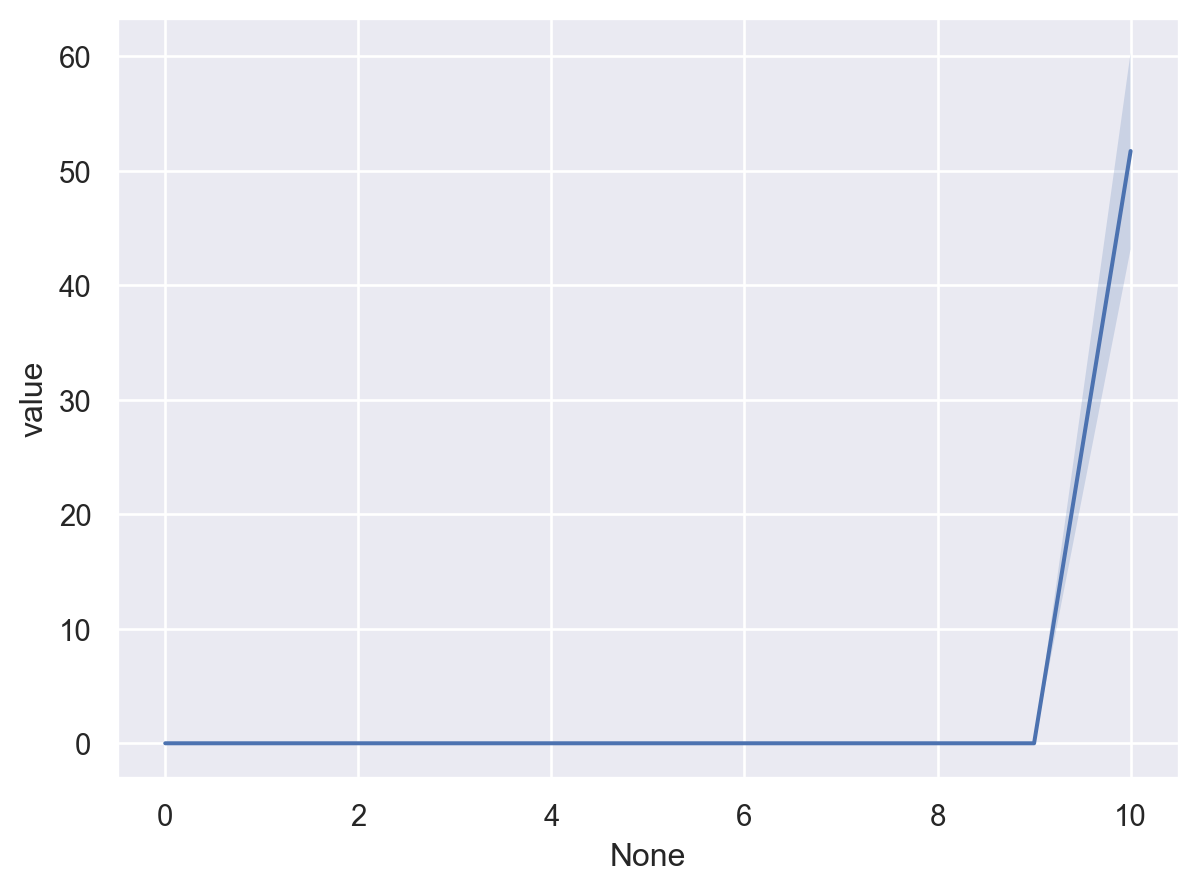

In [ ]:
watermark_acc_curve

[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [47.82608695652174,
  43.47826086956522,
  56.52173913043478,
  52.17391304347826,
  52.17391304347826,
  52.17391304347826,
  34.78260869565217,
  30.434782608695652,
  34.78260869565217,
  69.56521739130434]]

In [ ]:
import numpy as np
import pandas as pd


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (11,) + inhomogeneous part.

In [ ]:
watermark_acc_curve

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [52.17391304347826,
  52.17391304347826,
  52.17391304347826,
  60.869565217391305,
  43.47826086956522,
  47.82608695652174,
  52.17391304347826,
  56.52173913043478,
  43.47826086956522,
  56.52173913043478]]

In [ ]:
df = pd.DataFrame(watermark_acc_curve, index=range(len(watermark_acc_curve))).melt(ignore_index=False).reset_index()
df

index  variable      value
0        0         0        NaN
1        1         0        NaN
2        2         0        NaN
3        3         0        NaN
4        4         0        NaN
..     ...       ...        ...
105      6         9        NaN
106      7         9        NaN
107      8         9        NaN
108      9         9        NaN
109     10         9  56.521739

[110 rows x 3 columns]

In [ ]:
import itertools
import random
from scipy import stats

random_subgraphs = pickle.load(open(f'{data_dir}/random_subgraphs_{dataset_name}.pkl','rb'))
betas_random_raw__ = []
betas_random__ = []
for (subgraph,node_indices) in random_subgraphs:
    x_sub = subgraph.x
    y_sub = probas[node_indices]
    beta = solve_regression(x_sub, y_sub).clone().detach()
    betas_random_raw__.append(beta)
    beta = torch.sign(beta)
    betas_random__.append(beta)

subgraph_sigs = list(subgraph_dict.keys())
final_betas = torch.stack([torch.sign(history['betas'][k][-1]) for k in subgraph_sigs])


FileNotFoundError: [Errno 2] No such file or directory: '/Users/janedowner/Desktop/Desktop/IDEAL/Project_2/data/random_subgraphs_computers.pkl'

In [ ]:
# def create_random_subgraph(data, subgraph_size, mask=None, avoid_nodes=None, verbose=True):
#         num_nodes = data.num_nodes
#         num_selected_nodes = subgraph_size
#         nodes_random_order = torch.randperm(num_nodes)
#         if mask is not None:
#             nodes_random_order = torch.tensor([n.item() for n in nodes_random_order if mask[n.item()] is not False])
#         if avoid_nodes is not None:
#             nodes_random_order = torch.tensor([n.item() for n in nodes_random_order if n not in avoid_nodes])
#         selected_nodes = nodes_random_order[:num_selected_nodes]
#         if verbose==True:
#             print('selected_nodes:',selected_nodes)


#         sub_edge_index, _ = subgraph(selected_nodes, data.edge_index, relabel_nodes=True, num_nodes=num_nodes)
#         sub_data = Data(
#             x=data.x[selected_nodes] if data.x is not None else None,
#             edge_index=sub_edge_index,
#             y=data.y[selected_nodes] if data.y is not None else None,
#             train_mask=data.train_mask[selected_nodes] if data.train_mask is not None else None,
#             test_mask=data.test_mask[selected_nodes] if data.test_mask is not None else None,
#             val_mask=data.val_mask[selected_nodes] if data.val_mask is not None else None,
#         )

#         return sub_data, selected_nodes


# def generate_subgraph(data, dataset_name, kwargs, central_node=None, avoid_nodes=[], use_train_mask=True, max_num_nodes=None, show=True):
#     data = copy.deepcopy(data)
#     numSubgraphs = kwargs['numSubgraphs']
#     fraction      = kwargs['fraction']
        
#     if kwargs['method']=='khop':
#         assert central_node is not None
#         max_degree  = kwargs['khop_kwargs']['max_degree']
#         numHops     = kwargs['khop_kwargs']['numHops']
#         G = to_networkx(data, to_undirected=True)
#         degrees = dict(nx.degree(G))
#         if central_node is None:
#             ranked_node_indices = rank_training_nodes_by_degree(dataset_name, data, max_degree)
#             central_node = ranked_node_indices[0]
#         if dataset_name in ['CORA','CiteSeer','PubMed','Reddit','Reddit2','CS','Flickr','computers','photo']:
#             mask = torch.tensor([True]*len(data.x)) # initially, "mask" blocks nothing
#             if use_train_mask is True:
#                 mask = copy.deepcopy(data.train_mask)
#             if avoid_nodes is not None and len(avoid_nodes)>0:
#                 mask[avoid_nodes] = False
#             subgraph_node_idx = get_masked_subgraph_nodes(data, central_node, hops=numHops, mask=mask)
#             if max_num_nodes is not None:
#                 subgraph_node_idx = torch.tensor(random.sample(subgraph_node_idx.tolist(),max_num_nodes))
#             subgraph_node_idx, subgraph_edge_idx, _, _ = k_hop_subgraph(subgraph_node_idx, 0, edge_index=data.edge_index, num_nodes=data.num_nodes, relabel_nodes=True)
#         elif dataset_name=='PPI':
#             subgraph_node_idx, subgraph_edge_idx, _, _ = k_hop_subgraph(central_node, numHops, edge_index=data.edge_index, num_nodes=data.num_nodes, relabel_nodes=True)
#         data_sub = Data(x=data.x[subgraph_node_idx], edge_index=subgraph_edge_idx, y=data.y[subgraph_node_idx])
#         subgraph_signature = central_node
#     elif kwargs['method']=='random':
#         num_watermarked_nodes = int(fraction*(data.x.shape[0]))
#         subgraph_size = int(num_watermarked_nodes/numSubgraphs)
#         data_sub, subgraph_node_idx = create_random_subgraph(data, subgraph_size, data.train_mask, avoid_nodes)
#         subgraph_signature = '_'.join([str(s) for s in subgraph_node_idx.tolist()])
#     elif kwargs['method']=='random_walk_with_restart':
#         assert central_node is not None
#         restart_prob = kwargs['rwr_kwargs']['restart_prob']
#         max_steps    = kwargs['rwr_kwargs']['max_steps']
#         num_watermarked_nodes = int(fraction*(data.x.shape[0]))
#         subgraph_size = int(num_watermarked_nodes/numSubgraphs)
#         data_sub, subgraph_node_idx = create_rwr_subgraph(data, central_node, restart_prob=restart_prob, subgraph_size=subgraph_size, max_steps=max_steps, mask=data.train_mask, avoid_nodes=avoid_nodes)
#         subgraph_signature = '_'.join([str(s) for s in subgraph_node_idx.tolist()])

#     if show==True:
#         if kwargs['method']=='random':
#             title = f'random {fraction}-fraction subgraph'
#         elif kwargs['method']=='khop':
#             title = f'{numHops}-hop subgraph centered at node {central_node} (degree={degrees[central_node]})'
#         elif kwargs['method']=='random_walk_with_restart':
#             title = f'random walk w/ restart subgraph at node {central_node}, max steps={kwargs["rwr_kwargs"]["max_steps"]} and restart_prob={kwargs["rwr_kwargs"]["restart_prob"]}'
#         G_sub = to_networkx(data_sub, to_undirected=True)
#         plt.figure(figsize=(5, 3))
#         nx.draw_networkx(G_sub, with_labels=False,  node_color = 'blue', node_size=30)
#         plt.title(title)
#         plt.show()

#     return data_sub, subgraph_signature, subgraph_node_idx

# def create_rwr_subgraph(data, start_node, restart_prob=0.15, subgraph_size=50, max_steps=1000, mask=None, avoid_nodes=None):
#     G = to_networkx(data, to_undirected=True)
#     subgraph_nodes = set([start_node])
#     current_node = start_node

#     for _ in range(max_steps):
#         if len(subgraph_nodes) >= subgraph_size:
#             break
#         if random.random() < restart_prob:
#             current_node = start_node
#         else:
#             neighbors = list(G.neighbors(current_node))
#             if neighbors:
#                 current_node = random.choice(neighbors)
#                 if (mask is None or mask[current_node]) and (avoid_nodes is None or current_node not in avoid_nodes):
#                     subgraph_nodes.add(current_node)
#             else:
#                 current_node = start_node

#     subgraph_node_idx = torch.tensor(list(subgraph_nodes))
#     sub_edge_index, _ = subgraph(subgraph_node_idx, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes)
#     sub_data = Data(
#         x=data.x[subgraph_node_idx] if data.x is not None else None,
#         edge_index=sub_edge_index,
#         y=data.y[subgraph_node_idx] if data.y is not None else None,
#         train_mask=data.train_mask[subgraph_node_idx] if data.train_mask is not None else None,
#         test_mask=data.test_mask[subgraph_node_idx] if data.test_mask is not None else None,
#         val_mask=data.val_mask[subgraph_node_idx] if data.val_mask is not None else None,
#     )

#     return sub_data, subgraph_node_idx

# def gather_random_subgraphs_for_testing(data, dataset_name, 
#                                         max_degrees_choices=[20,50,100], 
#                                         frac_choices = [0.001,0.004,0.005,0.01], 
#                                         restart_prob_choices = [0,0.1,0.2], 
#                                         nHops_choices=[1,2,3], 
#                                         limit_khop_num_nodes=False):
#     # create blank subgraph_dict to fill
#     subgraph_kwargs =   {'method': 'random',  
#                          'fraction': None,
#                          'numSubgraphs': 1,
#                                 'khop_kwargs':   {'autoChooseSubGs': True,   'nodeIndices':  None,   'numHops': None,   'max_degree': None},
#                                 'random_kwargs': {},
#                                 'rwr_kwargs': {'restart_prob':None, 'max_steps':1000}
#                             }
    
#     if dataset_name=='computers':
#         max_degrees_choices = [20]

#     use_train_mask=True
#     num_ = 50
#     avoid_indices = []
#     subgraphs = []
#     for i in range(num_):
#         max_num_nodes=None
#         subgraph_kwargs['method'] = np.random.choice(['khop','random','random_walk_with_restart'])
#         fraction = subgraph_kwargs['fraction'] = np.random.choice(frac_choices)

#         print(f'Forming subgraph {i+1} of {num_}: {subgraph_kwargs['method']}',end='\r')
#         if subgraph_kwargs['method']=='khop':
#             if limit_khop_num_nodes==True:
#                 max_num_nodes = int(data.x.shape[0]*fraction)
#             subgraph_kwargs['khop_kwargs']['numHops'] = np.random.choice(nHops_choices)
#             maxDegree = subgraph_kwargs['khop_kwargs']['maxDegree'] = np.random.choice(max_degrees_choices)
#             random.seed(2575)
#             num_watermarked_nodes = int(fraction*len(data.train_mask.tolist()))
#             ranked_nodes = torch.tensor(rank_training_nodes_by_degree(dataset_name, data, max_degree=maxDegree)[:100])
#             idxs = torch.randperm(len(ranked_nodes))
#             ranked_nodes = ranked_nodes[idxs]
#             node_indices_to_watermark = ranked_nodes[:num_watermarked_nodes]
#             central_node = node_indices_to_watermark[0]
#         elif subgraph_kwargs['method']=='random_walk_with_restart':
#             max_num_nodes = int(data.x.shape[0]*fraction)
#             subgraph_kwargs['rwr_kwargs']['restart_prob'] = np.random.choice(restart_prob_choices)
#             ranked_nodes = torch.tensor(rank_training_nodes_by_degree(dataset_name, data, max_degree=maxDegree)[:100])
#             idxs = torch.randperm(len(ranked_nodes))
#             ranked_nodes = ranked_nodes[idxs]
#             node_indices_to_watermark = ranked_nodes[:num_watermarked_nodes]
#             central_node = node_indices_to_watermark[0]
#         elif subgraph_kwargs['method']=='random':
#             central_node=None


#         data_sub, _, subgraph_node_indices = generate_subgraph(data, dataset_name, subgraph_kwargs, central_node, avoid_indices, use_train_mask, max_num_nodes=max_num_nodes, show=False)
#         subgraphs.append((data_sub,subgraph_node_indices))
#         try:
#             avoid_indices += [node_index.item() for node_index in subgraph_node_indices]
#         except:
#             avoid_indices += [node_index.item() for node_index in subgraph_node_indices]

#     return subgraphs

random_subgraphs = gather_random_subgraphs_for_testing(data, dataset_name, max_degrees_choices=[20,50,100], frac_choices = [0.0025], nHops_choices=[2], limit_khop_num_nodes=True)


selected_nodes: tensor([12416, 11862,  3478,  3627, 11935,   820, 10365,  3758,  6146,  8676,
         8574,  4233,  6288,  1219,  7123,  2824,  5068,  4405, 11506,  9646,
          499,  4770,  2670, 11599, 12452, 10716,  1400,  1084,  9351,  9106,
         6072, 13522,   648,  5745])
selected_nodes: tensor([ 7838, 12312,  7232, 13536,   451,  8020,  7152,  8458,  2099,  1987,
        13540,  6725,  1895,  7527, 13234,  2825,  6519, 11242,  3861,   906,
         6510,  1139,  7681,  4718, 12925,  6499,  5582,  9639,  3425, 11775,
        13558,  6054, 13373,  4516])
subgraph_node_idx: tensor([    1,     2,     3,  ..., 13734, 13738, 13745])
max_num_nodes: 34
selected_nodes: tensor([  386,  7016,  8027, 13502, 12867,  8439, 13152,  3745, 10343,  6389,
         6183,  2232,  7835,  2123,  5264,  6113,  8147,  1416,  8397, 12408,
         1915,  8544,  9274,  8110, 11941, 12256,  3392,   363, 12038, 11525,
         7064,  4752, 10023,  8369])
selected_nodes: tensor([12745,  5696, 12236, 

In [ ]:
random_subgraphs_34 = pickle.load(open(f'{data_dir}/random_subgraphs_{dataset_name}_size_34.pkl','rb'))
random_subgraphs_varied = pickle.load(open(f'{data_dir}/random_subgraphs_{dataset_name}_size_varied.pkl','rb'))



In [ ]:
frac

0.01

In [ ]:
data.x.shape[0]*frac/10

13.752

In [ ]:
test_value = count_matches(final_betas)

n = len(subgraph_dict)
sample_size = 1000
means = []
stds = []
match_counts_lists = []
print(f'Computing # matches in groups of {n} beta tensors...')

''' random subgraphs '''
n_tuplets = list(itertools.combinations(range(len(random_subgraphs)), n))
n_tuplets = random.sample(n_tuplets, sample_size)
match_counts = []
for i in range(len(n_tuplets)):
    print(f'{i}/{len(n_tuplets)}',end='\r')
    bs = torch.vstack([betas_random__[j] for j in n_tuplets[i]])
    match_counts.append(count_matches(bs))
sample_mean = np.mean(match_counts)
sample_std = np.std(match_counts, ddof=1)   

print()
print(f'Empirical Sample Mean, Std: {np.round(sample_mean,3)}, {np.round(sample_std,3)}')
print(f'# Matches among the {n} watermarked betas: {test_value}')
print()
t_score = (test_value - sample_mean)/(sample_std/(np.sqrt(sample_size)))
p_value = 1 - stats.t.cdf(t_score, df=sample_size-1)
print(f't_score = {np.round(t_score,3)}, p-value = {np.round(p_value,5)}')

Computing # matches in groups of 5 beta tensors...
999/1000
Empirical Sample Mean, Std: 25.401, 27.539
# Matches among the 5 watermarked betas: 78

t_score = 60.399, p-value = 0.0


In [ ]:
with open

In [ ]:

sizes=[]
for i in range(len(random_subgraphs)):
    size = random_subgraphs[i][0].x.shape[0]
    sizes.append(size)
np.mean(sizes)

31.36

In [ ]:
np.mean([len(subgraph_dict[k]['nodeIndices']) for k in subgraph_sigs])

34.0

In [ ]:
test_value = count_matches(bs)
                 
print()
print(f'Population Mean, Std: {np.round(sample_mean,3)}, Empirical Std: {np.round(sample_std,3)}')
print(f'# Matches among the {n} watermarked betas: {test_value}')
print()
t_score = (test_value - sample_mean)/(sample_std/(np.sqrt(sample_size)))
p_value = 1 - stats.t.cdf(t_score, df=sample_size-1)
print(f't_score = {np.round(t_score,3)}, p-value = {np.round(p_value,5)}')

tensor([-1.0000e-04, -1.0000e-03, -1.0000e-01,  2.0000e-03])
tensor([0.9999, 0.9990, 0.9000, 1.0020])
tensor([0.9999, 0.9990, 0.9000, 1.0020])
tensor([-1.0000e-04, -1.0000e-03, -1.0000e-01,  2.0000e-03])


In [ ]:
6.01/20.489

0.29332812728781293

In [ ]:
35.54/13752

0.00258435136707388

In [ ]:
sizes=[]
for i in range(len(random_subgraphs)):
    size = random_subgraphs[i][0].x.shape[0]
    sizes.append(size)
np.mean(sizes)

35.54

In [ ]:
for sig in subgraph_dict.keys():
    this_watermark, data_sub, subgraph_node_indices = [subgraph_dict[sig][k] for k in ['watermark','subgraph','nodeIndices']]
    x_sub, y_sub = data_sub.x, probas[subgraph_node_indices]
    # if torch.sum(torch.sum(x_sub)).item()==1:
    print(x_sub.shape, torch.sum(x_sub), all_degrees[sig])

torch.Size([39, 767]) tensor(39.0000) 50
torch.Size([30, 767]) tensor(30.) 50
torch.Size([27, 767]) tensor(27.) 50
torch.Size([32, 767]) tensor(32.) 50
torch.Size([24, 767]) tensor(24.) 50
torch.Size([27, 767]) tensor(27.0000) 50
torch.Size([26, 767]) tensor(26.) 50
torch.Size([31, 767]) tensor(31.) 50
torch.Size([33, 767]) tensor(33.0000) 50
torch.Size([20, 767]) tensor(20.) 50
torch.Size([31, 767]) tensor(31.) 50
torch.Size([31, 767]) tensor(31.) 50
torch.Size([1, 767]) tensor(1.) 50
torch.Size([22, 767]) tensor(22.) 50
torch.Size([30, 767]) tensor(30.0000) 50
torch.Size([11, 767]) tensor(11.) 50
torch.Size([19, 767]) tensor(19.0000) 50
torch.Size([25, 767]) tensor(25.) 50


In [ ]:
beta_similarities_dict = history['beta_similarities']


import networkx as nx
import torch
import numpy as np
import pandas as pd
from torch_geometric.utils import to_networkx

def compute_subgraph_properties(data, subgraph_indices):
    G = to_networkx(data, to_undirected=True)
    subgraph = G.subgraph(subgraph_indices.tolist())
    
    if len(subgraph) == 0 or len(subgraph.edges()) == 0:
        avg_degree = 0
        clustering_coefficient = 0
        eigenvector_centrality = 0
    else:
        avg_degree = np.mean([d for n, d in subgraph.degree()])
        clustering_coefficient = nx.average_clustering(subgraph)
        eigenvector_centrality = np.mean(list(nx.eigenvector_centrality_numpy(subgraph).values()))
    
    return avg_degree, clustering_coefficient, eigenvector_centrality

def correlate_properties_with_similarity(data, subgraph_dict, beta_similarities_dict):
    properties = []
    similarities = []
    for sig in subgraph_dict.keys():
        subgraph_indices = subgraph_dict[sig]['nodeIndices']
        avg_degree, clustering_coefficient, eigenvector_centrality = compute_subgraph_properties(data, subgraph_indices)
        properties.append([avg_degree, clustering_coefficient, eigenvector_centrality])
        similarities.append(beta_similarities_dict[sig].item())
    
    df = pd.DataFrame(properties, columns=['Avg_Degree', 'Clustering_Coefficient', 'Eigenvector_Centrality'])
    df['Beta_Similarity'] = similarities
    
    # Replace NaN values with 0
    df.fillna(0, inplace=True)
    
    correlation_matrix = df.corr(method='spearman')  # or 'kendall'
    print(correlation_matrix)

# Example usage
correlate_properties_with_similarity(data, subgraph_dict, beta_similarities_dict)

                        Avg_Degree  Clustering_Coefficient  \
Avg_Degree                1.000000               -0.103030   
Clustering_Coefficient   -0.103030                1.000000   
Eigenvector_Centrality   -0.539394                0.321212   
Beta_Similarity           0.127273               -0.381818   

                        Eigenvector_Centrality  Beta_Similarity  
Avg_Degree                           -0.539394         0.127273  
Clustering_Coefficient                0.321212        -0.381818  
Eigenvector_Centrality                1.000000        -0.369697  
Beta_Similarity                      -0.369697         1.000000  


In [ ]:
num_edges, vars = [],[]
for sig in subgraph_dict:
    subgraph = subgraph_dict[sig]['subgraph']
    num_edges.append(subgraph.edge_index.shape[1])
    internode_var = torch.var(subgraph.x,dim=0)
    internode_var = torch.sum(internode_var)
    vars.append(internode_var)

num_edges = torch.tensor(num_edges)
vars = torch.tensor(vars)

def check_size_and_density(subgraph_data):
    num_nodes = subgraph_data.num_nodes
    num_edges = subgraph_data.num_edges
    density = num_edges / (num_nodes * (num_nodes - 1) / 2)
    return density

# Example usage
densities = []
for sig in subgraph_dict.keys():
    subgraph_data = subgraph_dict[sig]['subgraph']
    density = check_size_and_density(subgraph_data)
    densities.append(density)
densities = torch.tensor(densities)

def examine_centrality(data, subgraph_dict):
    G_ = to_networkx(data, to_undirected=True)
    degrees = dict(nx.degree(G_))
    all_avg_degrees = []
    for sig in subgraph_dict.keys():
        nodeIndices = subgraph_dict[sig]['nodeIndices']
        degrees_ = [degrees[idx.item()] for idx in nodeIndices]
        avg_degree = np.mean(degrees_)
        all_avg_degrees.append(avg_degree)

    return all_avg_degrees

# Example usage
centralities = torch.tensor(examine_centrality(data, subgraph_dict))

print(torch.argsort(num_edges))
print(torch.argsort(vars))
print(torch.argsort(densities))
print(torch.argsort(centralities))


tensor([0, 2, 7, 5, 4, 6, 1, 8, 9, 3])
tensor([7, 9, 0, 8, 3, 6, 1, 5, 4, 2])
tensor([0, 2, 7, 5, 4, 6, 1, 8, 9, 3])
tensor([0, 5, 8, 2, 4, 6, 1, 9, 7, 3])


In [ ]:
import pandas as pd

beta_similarities_dict = history['beta_similarities']

def visualize_subgraph_with_original_indices(data, subgraph_indices):
    subgraph = data.subgraph(subgraph_indices)
    G_sub = to_networkx(subgraph, to_undirected=True)
    plt.figure(figsize=(5, 3))
    nx.draw_networkx(G_sub, with_labels=True, node_color='blue', node_size=30)
    plt.show()

def analyze_features_with_original_indices(data, subgraph_indices):
    node_features = data.x[subgraph_indices]
    subgraph_indices_set = set(subgraph_indices.tolist())
    mask = torch.tensor([(src in subgraph_indices_set and dst in subgraph_indices_set) for src, dst in data.edge_index.T.tolist()])
    edge_indices = data.edge_index[:, mask]
    print(f'Node Features: {node_features}')
    print(f'Edge Indices: {edge_indices}')

def check_size_and_density_with_original_indices(data, subgraph_indices):
    num_nodes = len(subgraph_indices)
    subgraph_indices_set = set(subgraph_indices.tolist())
    mask = torch.tensor([(src in subgraph_indices_set and dst in subgraph_indices_set) for src, dst in data.edge_index.T.tolist()])
    num_edges = torch.sum(mask).item()
    density = num_edges / (num_nodes * (num_nodes - 1) / 2) if num_nodes > 1 else 0
    print(f'Number of Nodes: {num_nodes}, Number of Edges: {num_edges}, Density: {density}')

def examine_centrality_with_original_indices(data, subgraph_indices):
    G = to_networkx(data, to_undirected=True)
    centrality = nx.degree_centrality(G)
    subgraph_centrality = {node: centrality[node] for node in subgraph_indices.tolist()}
    print(f'Node Centrality: {subgraph_centrality}')

def investigate_feature_distribution_with_original_indices(data, subgraph_indices):
    node_features = data.x[subgraph_indices]
    feature_means = torch.mean(node_features, dim=0)
    feature_stddevs = torch.std(node_features, dim=0)
    print(f'Feature Means: {feature_means}')
    print(f'Feature Standard Deviations: {feature_stddevs}')

def compute_subgraph_properties_with_original_indices(data, subgraph_indices):
    G = to_networkx(data, to_undirected=True)
    subgraph = G.subgraph(subgraph_indices.tolist())
    if len(subgraph) == 0 or len(subgraph.edges()) == 0:
        avg_degree = 0
        clustering_coefficient = 0
        eigenvector_centrality = 0
    else:
        avg_degree = np.mean([d for n, d in subgraph.degree()])
        clustering_coefficient = nx.average_clustering(subgraph)
        eigenvector_centrality = np.mean(list(nx.eigenvector_centrality_numpy(subgraph).values()))
    return avg_degree, clustering_coefficient, eigenvector_centrality

def correlate_properties_with_similarity(data, subgraph_dict, beta_similarities_dict):
    properties = []
    similarities = []
    for sig in subgraph_dict.keys():
        subgraph_indices = subgraph_dict[sig]['nodeIndices']
        avg_degree, clustering_coefficient, eigenvector_centrality = compute_subgraph_properties_with_original_indices(data, subgraph_indices)
        
        properties.append([avg_degree, clustering_coefficient, eigenvector_centrality])
        similarities.append(beta_similarities_dict[sig].item())
    
    df = pd.DataFrame(properties, columns=['Avg_Degree', 'Clustering_Coefficient', 'Eigenvector_Centrality'])
    df['Beta_Similarity'] = similarities
    
    # Replace NaN values with 0 or use another strategy to handle NaNs
    df.fillna(0, inplace=True)
    
    correlation_matrix = df.corr(method='spearman')  # or 'kendall'
    print(correlation_matrix)


# # Example usage
# for sig in subgraph_dict.keys():
#     subgraph_indices = subgraph_dict[sig]['nodeIndices']
#     visualize_subgraph_with_original_indices(data, subgraph_indices)
#     analyze_features_with_original_indices(data, subgraph_indices)
#     check_size_and_density_with_original_indices(data, subgraph_indices)
#     examine_centrality_with_original_indices(data, subgraph_indices)
#     investigate_feature_distribution_with_original_indices(data, subgraph_indices)

# # Example usage
# correlate_properties_with_similarity(data, subgraph_dict, beta_similarities_dict)

In [ ]:
subgraph.edge_index

tensor([[13, 40, 19, 38],
        [38, 19, 40, 13]])

## Many options, compared:

In [ ]:
compare_dict = None

get_coef_wmk    = lambda name: float(name.split(' ')[1].split('=')[-1][:-1])
get_percentile  = lambda name: int(name.split(' ')[4].split('-')[0])
get_frac        = lambda name: float(name.split(' ')[7].split('=')[-1][:-1])
get_clf_epochs  = lambda name: int(name.split(' ')[-2])

sorted_keys = dict(sorted(compare_dict.items(), key=lambda item: np.mean([item[1]['percent_match'],100*item[1]['train acc']]))).keys()
for k in sorted_keys:
    print(k)
    print('match:',compare_dict[k]['percent_match'],'acc:',compare_dict[k]['train acc'].item())
    print()

#b = compare_dict_subgraph_unimportant[list(sorted_keys)[-1]]['beta']
##w = compare_dict_subgraph_unimportant[list(sorted_keys)[-1]]['watermark']
#torch.sum(b*w)
best_coef_wmk = get_coef_wmk(list(sorted_keys)[-1])
best_perc = get_percentile(list(sorted_keys)[-1])
best_frac = get_frac(list(sorted_keys)[-1])
best_clf_ep = get_clf_epochs(list(sorted_keys)[-1])

## Best current option -- full training

RESULTS


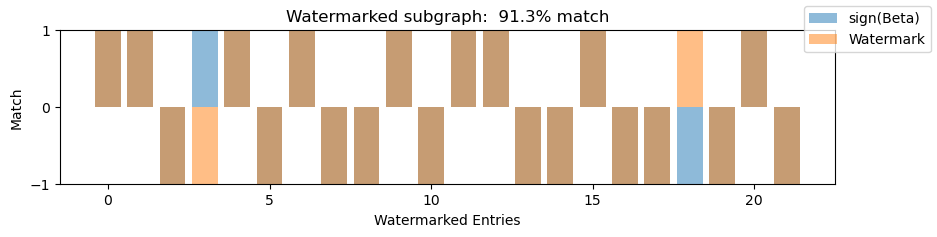

COMPARISON AGAINST RANDOM SUBGRAPHS


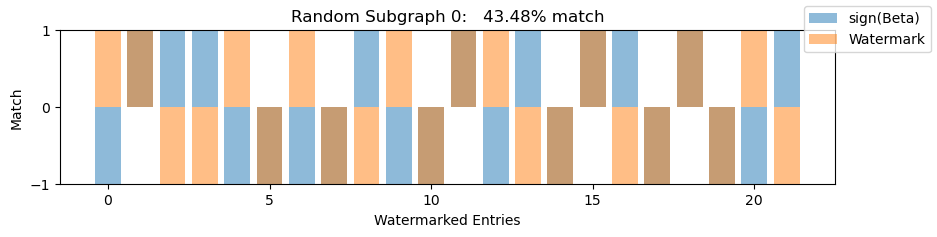

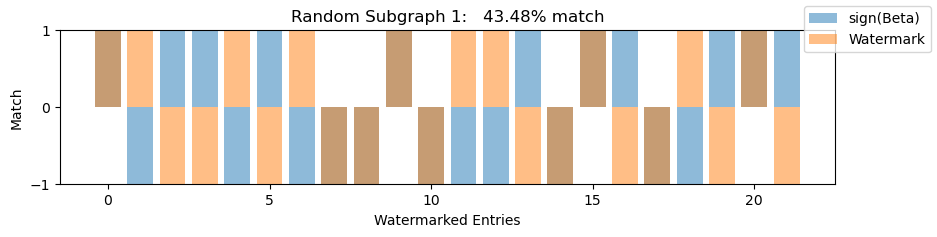

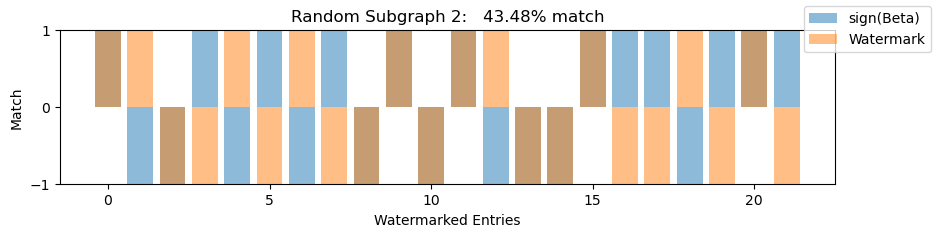

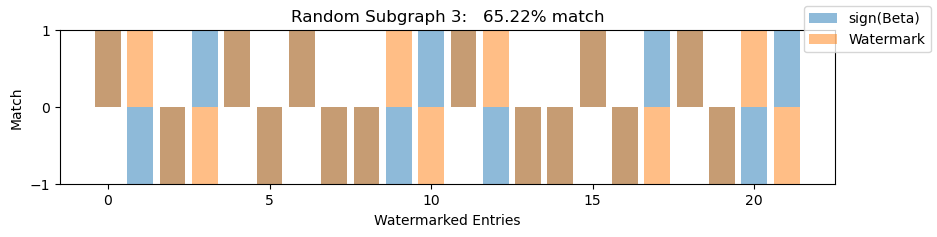

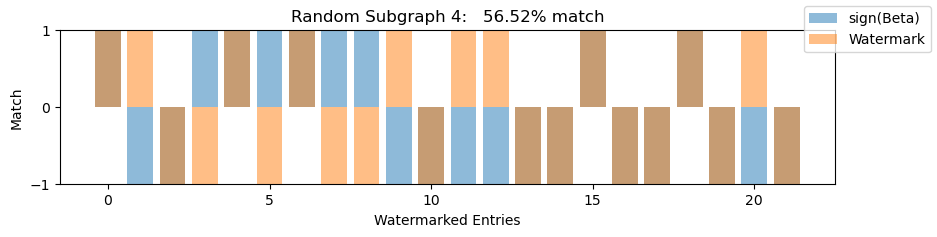

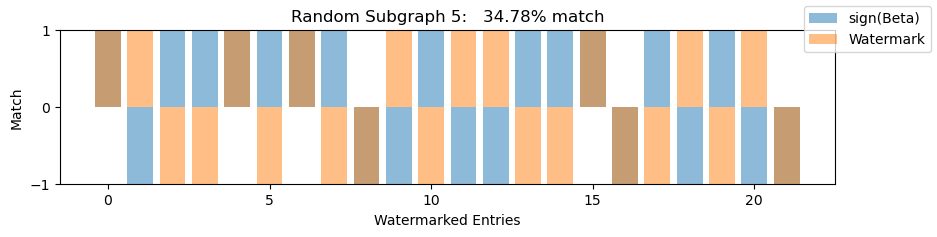

In [ ]:
watermark_kwargs['unimportant_percentile']=best_perc
watermark_kwargs['fancy_selection_kwargs']['clf_only_epochs']=best_clf_ep
subgraph_kwargs['random_kwargs']['fraction']=best_frac
watermark_kwargs['coefWmk']=best_coef_wmk
compare_unimportant_against_random=False

if dataset_name in ['CORA','CiteSeer','PubMed','Reddit','Flickr','photo','computers']:
    node_classifier, history, subgraph_dict, all_feature_importances, all_watermark_indices, probas = train(data, dataset_name, lr, epochs, 
                                                                                                            node_classifier_kwargs, watermark_kwargs, 
                                                                                                            subgraph_kwargs, densify_kwargs, augment_kwargs, save=True)

##

beta_dict = history['betas']
subgraph_sig = list(beta_dict.keys())[0]
nonzero_indices = torch.where(watermark!=0)[0]
watermark_non_zero = watermark[nonzero_indices]

start   = watermark_kwargs['clf_only_epochs']
end     = len(beta_dict[list(beta_dict.keys())[0]])
# n = -1
print('RESULTS')
fig, ax = plt.subplots(1, 1,figsize=(10,2))
beta    = beta_dict[subgraph_sig ][-1].clone().detach()
sign_beta = torch.sign(beta[nonzero_indices])
matches = len(torch.where(sign_beta==watermark_non_zero)[0])
percent_match = np.round(100*matches/len(watermark_non_zero),2)

ax.bar(range(len(sign_beta[:n])),           sign_beta[:n].numpy(),          label='sign(Beta)', alpha=0.5)
ax.bar(range(len(watermark_non_zero[:n])),  watermark_non_zero[:n].numpy(), label='Watermark',  alpha=0.5)
ax.set_title(f'Watermarked subgraph:  {percent_match}% match')
ax.set_xlabel('Watermarked Entries')
ax.set_ylabel('Match')
ax.set_ylim(-1,1)
ax.set_yticks([-1,0,1])
fig.legend()
plt.show()

print('COMPARISON AGAINST RANDOM SUBGRAPHS')
numSubgraphs=6
alpha=1e3
random_betas_dict, random_beta_similarities_dict = extract_results_random_subgraphs(data, dataset_name, best_frac*numSubgraphs, numSubgraphs, alpha, watermark, probas, node_classifier, subgraph_kwargs, use_train_mask=False)
keys = random_betas_dict.keys()
for i, subgraph_sig in enumerate(keys):
    # print(random_beta_similarities_dict[k].item())

    fig, ax = plt.subplots(1, 1,figsize=(10,2))
    beta    = random_betas_dict[subgraph_sig][-1].clone().detach()
    sign_beta = torch.sign(beta[nonzero_indices])
    bw = np.round(random_beta_similarities_dict[subgraph_sig].item(),2)
    matches = len(torch.where(sign_beta==watermark_non_zero)[0])
    percent_match = np.round(100*matches/len(watermark_non_zero),2)

    ax.bar(range(len(sign_beta[:n])),           sign_beta[:n].numpy(),          label='sign(Beta)', alpha=0.5)
    ax.bar(range(len(watermark_non_zero[:n])),  watermark_non_zero[:n].numpy(), label='Watermark',  alpha=0.5)
    ax.set_title(f'Random Subgraph {i}:   {percent_match}% match')
    ax.set_xlabel('Watermarked Entries')
    ax.set_ylabel('Match')
    ax.set_ylim(-1,1)
    ax.set_yticks([-1,0,1])
    fig.legend()
plt.show()

## GRID SEARCH

In [ ]:
all_indices

[tensor([652, 512, 118, 263, 632, 537, 259, 103, 668, 358, 318, 465, 114, 699,
         644, 608, 294, 129, 175,  13, 295,  64, 208]),
 tensor([471, 213, 561, 208, 201, 541, 684, 191, 219, 732, 128, 239, 642, 155,
          82, 287, 171, 304, 350, 690,  71, 198, 529]),
 tensor([558, 234, 635, 494, 291, 562, 372,  55, 468, 256, 355, 356,  18, 482,
         594, 236, 581, 502, 359, 616,  78,  62, 221]),
 tensor([441, 278, 164, 691, 621, 675, 220, 197, 662,  89, 458, 196, 221, 328,
         620, 144, 327, 219, 223, 201, 665, 744,  79]),
 tensor([323, 148, 595, 469, 515, 555,  66, 127, 485, 278, 297, 567,  64, 126,
         274, 635, 378, 527, 585, 561,  52, 298,  40]),
 tensor([  9, 683, 573, 354, 300, 223, 706, 541, 437, 131, 466, 636,  49, 537,
         360, 363, 405, 173, 411, 692, 369, 389, 656]),
 tensor([184, 297, 463, 363, 670, 150, 116, 678, 285, 489, 423, 252, 138,  48,
         541, 329, 412, 303,   1, 502,  79, 277, 380]),
 tensor([ 88, 508, 108,  93, 666, 258, 459, 448, 514, 5

In [ ]:
concat_indices

tensor([ 74, 195, 499, 463, 170,  83, 355, 399, 454, 160, 458, 724, 320, 500,
        449, 119, 513,  23,  89, 557, 484, 223, 175])

In [ ]:
# all_indices
indices

tensor([439,  12, 445,  99, 215,  78, 180, 482, 634, 130, 639, 570, 485, 141,
        726, 447, 133, 374, 320, 376,  72, 658, 575])

In [ ]:
torch.topk(1/torch.tensor(list(beta_all_sub.abs())),23)

torch.return_types.topk(
values=tensor([98647.6562, 44980.4492, 44899.4648, 33666.1836, 27683.6250, 21407.2246,
        18521.9434, 16209.3447, 15895.3760, 13966.3486, 12648.3975, 11209.0244,
        11182.5625,  9724.1611,  9129.8594,  9015.8457,  7754.1909,  7356.2476,
         6480.4902,  5922.4180,  5750.9590,  5521.0752,  4625.4204]),
indices=tensor([ 74, 195, 499, 463, 170,  83, 355, 399, 454, 160, 458, 724, 320, 500,
        449, 119, 513,  23,  89, 557, 484, 223, 175]))

In [ ]:
subgraph_key = list(history['betas'].keys())[0]
beta = history['betas'][subgraph_key][-1].clone().detach()
nonzeros=torch.where(watermark!=0)[0]
print(len(torch.where(torch.sign(beta[nonzeros])==watermark[nonzeros])[0])/len(nonzeros))

0.8260869565217391


RESULTS


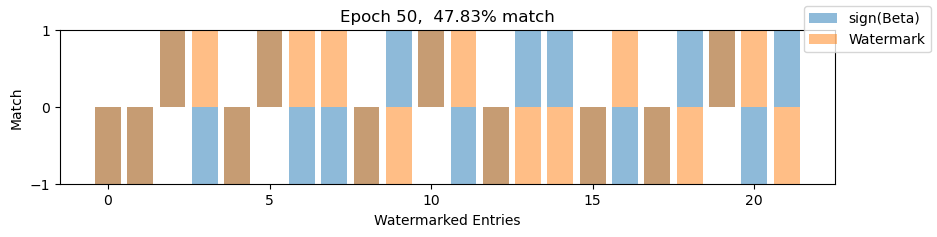

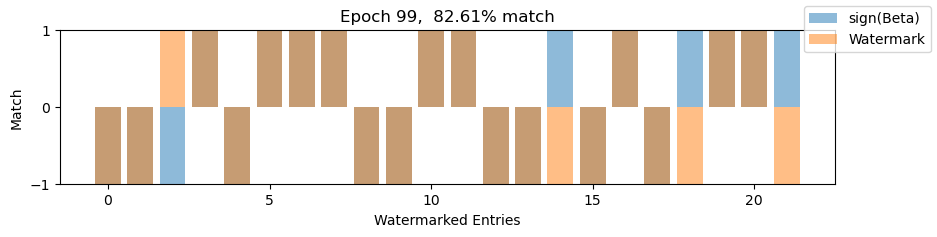

COMPARISON AGAINST RANDOM SUBGRAPHS


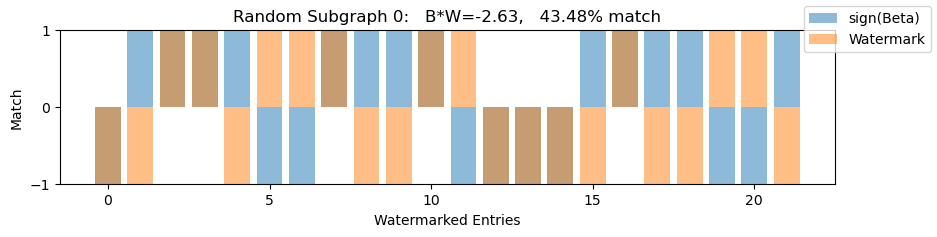

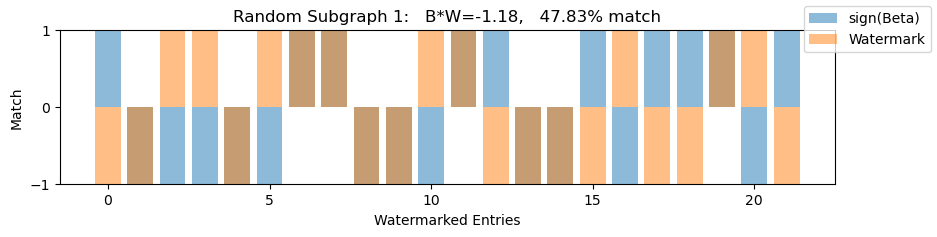

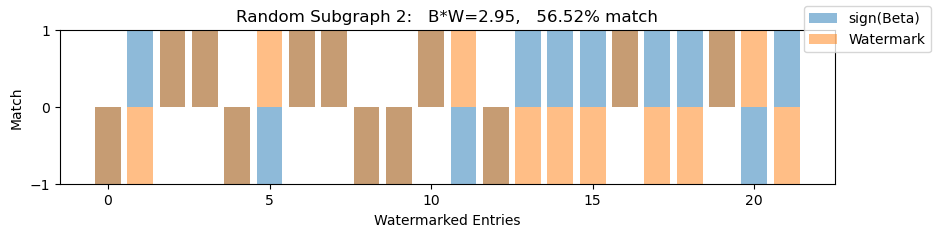

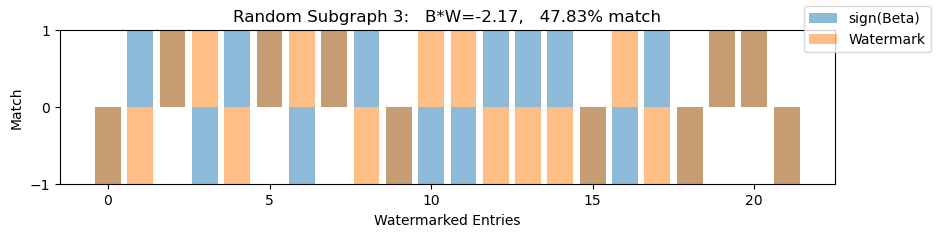

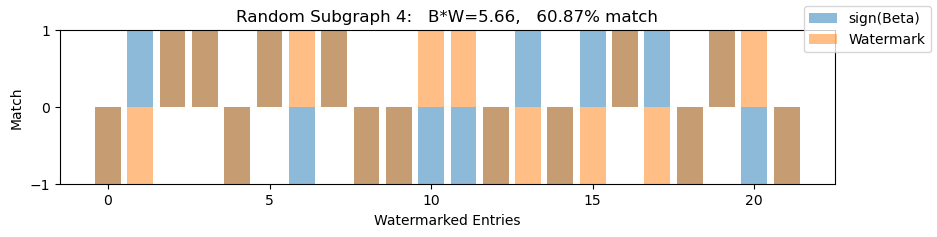

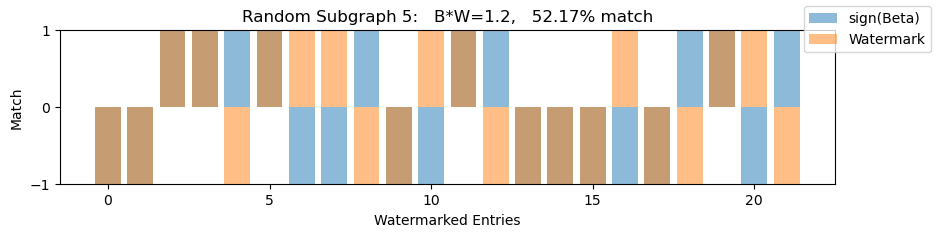

In [ ]:
beta_dict = history['betas']
subgraph_sig = list(beta_dict.keys())[0]
nonzero_indices = torch.where(watermark!=0)[0]
watermark_non_zero = watermark[nonzero_indices]

start   = watermark_kwargs['clf_only_epochs']
end     = len(beta_dict[list(beta_dict.keys())[0]])
n = -1
print('RESULTS')
for i in [0,-1]:
    fig, ax = plt.subplots(1, 1,figsize=(10,2))
    beta    = beta_dict[subgraph_sig ][i].clone().detach()
    sign_beta = torch.sign(beta[nonzero_indices])
    matches = len(torch.where(sign_beta==watermark_non_zero)[0])
    percent_match = np.round(100*matches/len(watermark_non_zero),2)

    ax.bar(range(len(sign_beta[:n])),           sign_beta[:n].numpy(),          label='sign(Beta)', alpha=0.5)
    ax.bar(range(len(watermark_non_zero[:n])),  watermark_non_zero[:n].numpy(), label='Watermark',  alpha=0.5)
    ax.set_title(f'Epoch {start+i if i>=0 else start+end+i},  {percent_match}% match')
    ax.set_xlabel('Watermarked Entries')
    ax.set_ylabel('Match')
    ax.set_ylim(-1,1)
    ax.set_yticks([-1,0,1])
    fig.legend()
plt.show()

print('COMPARISON AGAINST RANDOM SUBGRAPHS')
numSubgraphs=6
alpha=1e3
random_betas_dict, random_beta_similarities_dict = extract_results_random_subgraphs(data, dataset_name, frac*numSubgraphs, numSubgraphs, alpha, watermark, probas, node_classifier, subgraph_kwargs, use_train_mask=False)
keys = random_betas_dict.keys()
for i, subgraph_sig in enumerate(keys):
    # print(random_beta_similarities_dict[k].item())

    fig, ax = plt.subplots(1, 1,figsize=(10,2))
    beta    = random_betas_dict[subgraph_sig][-1].clone().detach()
    sign_beta = torch.sign(beta[nonzero_indices])
    bw = np.round(random_beta_similarities_dict[subgraph_sig].item(),2)
    matches = len(torch.where(sign_beta==watermark_non_zero)[0])
    percent_match = np.round(100*matches/len(watermark_non_zero),2)

    ax.bar(range(len(sign_beta[:n])),           sign_beta[:n].numpy(),          label='sign(Beta)', alpha=0.5)
    ax.bar(range(len(watermark_non_zero[:n])),  watermark_non_zero[:n].numpy(), label='Watermark',  alpha=0.5)
    ax.set_title(f'Random Subgraph {i}:   B*W={bw},   {percent_match}% match')
    ax.set_xlabel('Watermarked Entries')
    ax.set_ylabel('Match')
    ax.set_ylim(-1,1)
    ax.set_yticks([-1,0,1])
    fig.legend()
plt.show()

In [ ]:
frac

0.01

enumerate_over_me: range(0, 6)
selected_nodes: tensor([ 8747, 12935, 12177, 12519,  7722,  4230,  5127,  1505,  7187,  6807,
         9523,  7935, 11761,  2432,  6416, 10512,  5268, 10687,  9013, 11458,
         2255,  4606, 12601,  4702,   936,  2972,  7875, 12350,  7803,  2597,
          503,    12,   668, 13689,    54,  9173, 11528, 11268,  2709,  5033,
         8393,   579,  9731,    16, 12451,  4746,  4185, 12754,  2514,  2195,
         5652, 11280,  5067,  9922, 12650,  9828, 12164,  1002,  5779, 10967,
          638,  1885, 11435,  3845,  2009,  7595,  8390,  9503, 13127, 10851,
          617, 12282,  3427,  2820, 11258,  3385,  3304,  6972, 11033,  9626,
         6560,  8208,  3737,  7920, 10123,  9241, 10873,  4484,  9964,  6703,
         4226,  6268,  8075,  8748, 11277,   825, 10831,  9115,  3096,  4288,
        11230, 12720,  8165,  3330,  6145,  7101,  9244,  7832,  8674,  6187,
         8323,  9259,  6877, 13730,  3952,  5889,   624,  2349,  9094,  8215,
        13114,  8

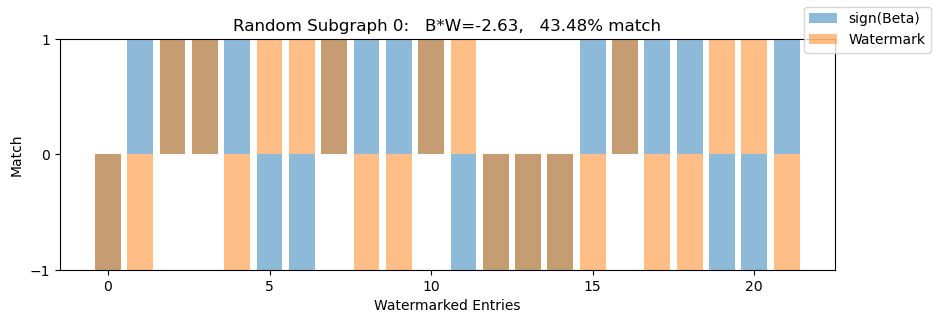

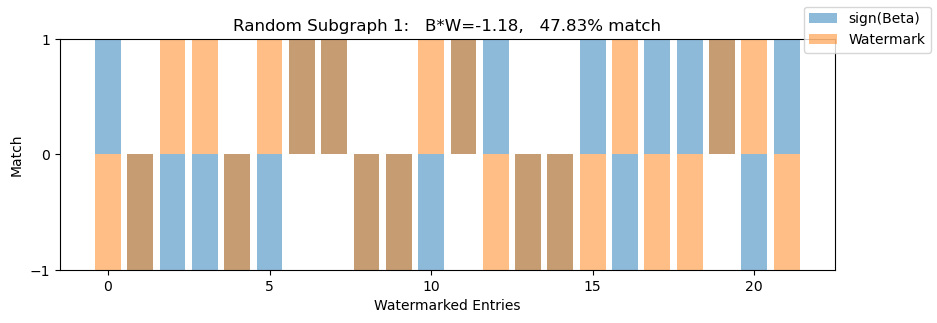

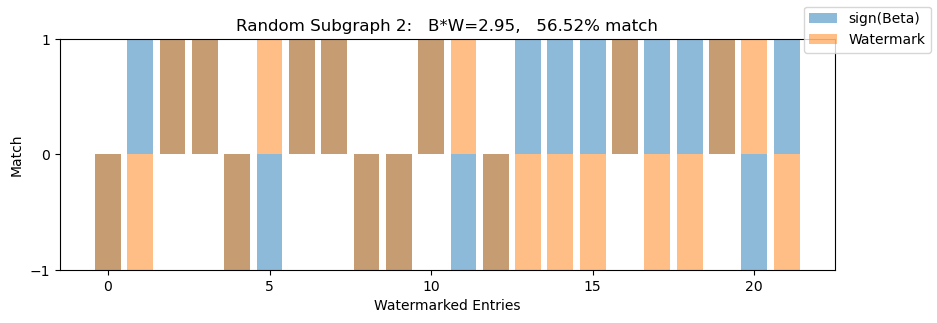

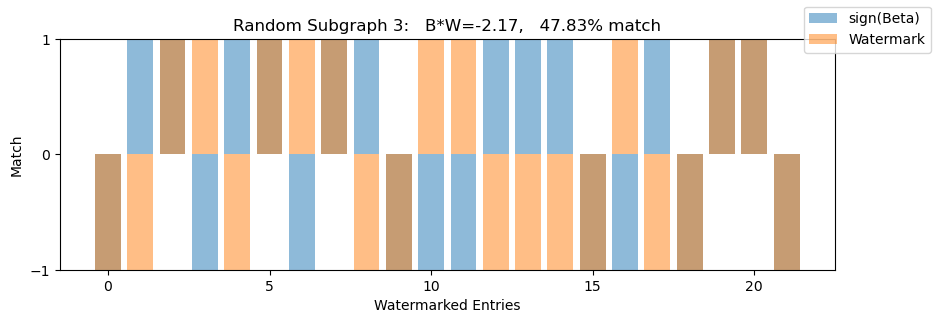

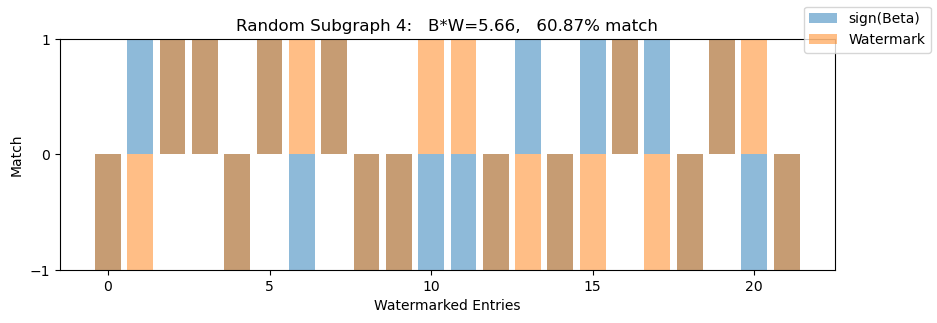

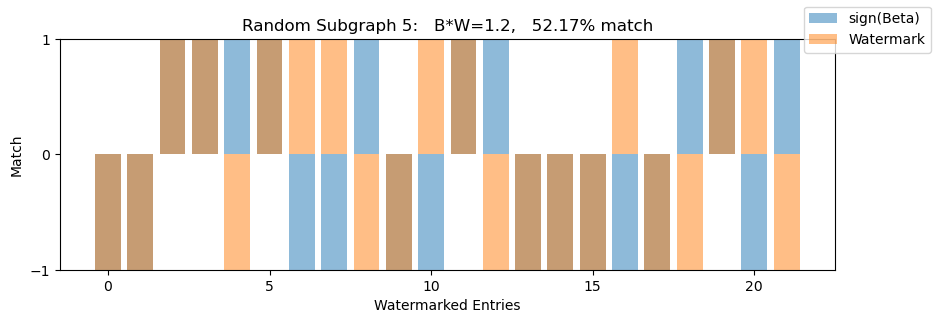

In [ ]:
random_betas_dict

dict_values([tensor(-1.5490, grad_fn=<SumBackward0>), tensor(1.9462, grad_fn=<SumBackward0>), tensor(2.9998, grad_fn=<SumBackward0>), tensor(-0.9422, grad_fn=<SumBackward0>), tensor(0.0271, grad_fn=<SumBackward0>)])

In [ ]:
def get_masked_subgraph_nodes(data, central_node, hops=2, mask=None, handle_small_subgraphs='accept'):
    ''' 
    In some graphs, nodes are split train/val/test. This extracts the 
    subgraph nodes belonging to a certain subset, and *then* handing this
    these nodes to k_hop_subgraph to construct the result.
    '''
    seen_nodes = set()
    nodes_to_explore = set([central_node])
    subgraph_edge_list = []

    for hop in range(hops):
        nodes_added_this_hop=False
        nodes_to_explore_temp = set()  
        for this_central_node in nodes_to_explore:
            if this_central_node not in seen_nodes:
                seen_nodes.add(this_central_node)
                this_edge_index = get_1_hop_edge_index(data, this_central_node, mask=mask)
                for [n0, n1] in this_edge_index.T.tolist():
                    if [n0, n1] not in subgraph_edge_list and [n1, n0] not in subgraph_edge_list:
                        subgraph_edge_list.append([n0, n1])
                    if n0 != this_central_node and n0 not in seen_nodes:
                        nodes_added_this_hop=True
                        nodes_to_explore_temp.add(n0)
                    if n1 != this_central_node and n1 not in seen_nodes:
                        nodes_added_this_hop=True
                        nodes_to_explore_temp.add(n1)
        nodes_to_explore = nodes_to_explore.union(nodes_to_explore_temp)
        if nodes_added_this_hop==False:
            if handle_small_subgraphs=='skip':
                return None
            elif handle_small_subgraphs=='accept':
                break

    subgraph_edge_index = torch.tensor(subgraph_edge_list).T
    if hops==0 or len(subgraph_edge_list)==0:
        original_node_ids = torch.concat([torch.unique(subgraph_edge_index),torch.tensor([central_node])]).int()
    else:
        original_node_ids = torch.unique(subgraph_edge_index)
    original_node_ids, _ = torch.sort(original_node_ids)
    return original_node_ids

def generate_subgraph(data, dataset_name, node_index_to_watermark=None, subgraph_method='k_hops', numHops=None, handle_small_subgraphs='skip', show=True):
    assert handle_small_subgraphs in ['accept','skip']

    data = copy.deepcopy(data)
    G = to_networkx(data, to_undirected=True)
    degrees = dict(nx.degree(G))

    assert subgraph_method in ['k_hop', 'simple_subset']
    if subgraph_method=='k_hops':
        assert numHops is not None
    if subgraph_method=='simple_subset':
        assert node_index_to_watermark is not None
    if node_index_to_watermark is None:
        ranked_node_indices = rank_training_nodes_by_degree(dataset_name, data)
        node_index_to_watermark = ranked_node_indices[0]


    if subgraph_method=='k_hop':
        if dataset_name in ['CORA','CiteSeer','PubMed']:
            subgraph_node_idx = get_masked_subgraph_nodes(data, node_index_to_watermark, hops=numHops, mask=data.train_mask, handle_small_subgraphs=handle_small_subgraphs)
            if handle_small_subgraphs=='skip' and subgraph_node_idx==None:
                print(f"Not enough valid neighbors at provided node ({node_index_to_watermark}) -- skipping")
                return None
            elif handle_small_subgraphs=='skip' and subgraph_node_idx is not None:
                print(f'valid subgraph at node {node_index_to_watermark}')
            subgraph_node_idx, subgraph_edge_idx, _, _ = k_hop_subgraph(subgraph_node_idx, 0, edge_index=data.edge_index, num_nodes=data.num_nodes, relabel_nodes=True)
        elif dataset_name=='PPI':
            subgraph_node_idx, subgraph_edge_idx, _, _ = k_hop_subgraph(node_index_to_watermark, numHops, edge_index=data.edge_index, num_nodes=data.num_nodes, relabel_nodes=True)
        subgraph_node_features, subgraph_y = data.x[subgraph_node_idx], data.y[subgraph_node_idx]
    elif subgraph_method=='simple_subset':
        subgraph_edge_idx, _ = subgraph(node_index_to_watermark, data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes)
        subgraph_node_features = data.x[node_index_to_watermark.tolist()]
        subgraph_node_idx = node_index_to_watermark
        subgraph_y = data.y[subgraph_node_idx]
        
    data_sub = Data(x=subgraph_node_features, edge_index=subgraph_edge_idx, y=subgraph_y)

    if show==True:
        G_sub = to_networkx(data_sub, to_undirected=True)
        plt.figure(figsize=(5, 3))
        nx.draw_networkx(G_sub, with_labels=False,  node_color = 'blue', node_size=30)
        plt.title(f'{numHops}-hop subgraph centered at node {node_index_to_watermark} (degree={degrees[node_index_to_watermark]})')
        plt.show()

    return data_sub, node_index_to_watermark, subgraph_node_idx


def collect_subgraphs_within_single_graph_for_watermarking(data, dataset_name, node_indices_to_watermark, subgraph_method='k_hop', numHops=None, handle_small_subgraphs='accept'):
    assert subgraph_method in ['k_hop','simple_subset']
    subgraph_dict = {}
    if subgraph_method=='k_hop':
        for count, i in enumerate(node_indices_to_watermark):
            print(f'Forming subgraph {count+1} of {len(node_indices_to_watermark)}',end='\r')
            ret = generate_subgraph(data, dataset_name, node_index_to_watermark=i, subgraph_method=subgraph_method, numHops=numHops, handle_small_subgraphs=handle_small_subgraphs, show=False)
            if handle_small_subgraphs=='skip' and ret==None:
                pass
            else:
                data_sub, _, subgraph_node_indices = ret
                subgraph_dict[i] = {'subgraph': data_sub, 'nodeIndices': subgraph_node_indices}
    elif subgraph_method=='simple_subset':
        for i in range(len(node_indices_to_watermark)):
            ret = generate_subgraph(data, dataset_name, node_index_to_watermark=node_indices_to_watermark[i], subgraph_method=subgraph_method, numHops=numHops, handle_small_subgraphs=handle_small_subgraphs, show=False)
            if handle_small_subgraphs=='skip' and ret==None:
                pass
            else:
                data_sub, _, subgraph_node_indices = ret
                subgraph_dict[i] = {'subgraph': data_sub, 'nodeIndices': subgraph_node_indices}
    return subgraph_dict

def analyze_subgraphs(data, dataset_name, watermark, node_classifier, nodeIndices=None, node_selection_method = 'random', pTest=None, subgraph_method='k_hop', numHops=2, handle_small_subgraphs='accept'):
    assert node_selection_method in ['random','provided']
    if node_selection_method == 'random':
        assert pTest is not None
        num_nodes = data.x.shape[0]
        k = int(pTest*num_nodes)
        nodeIndices = random.sample(list(range(num_nodes)),k) 
    elif node_selection_method == 'provided':
        assert nodeIndices is not None
    if subgraph_method=='k_hop':
        assert numHops is not None

    subgraph_dict = collect_subgraphs_within_single_graph_for_watermarking(data, dataset_name, nodeIndices, subgraph_method, numHops, handle_small_subgraphs=handle_small_subgraphs)
    nodeIndices = list(subgraph_dict.keys())
    if subgraph_method=='k_hop':
        betas_dict  = {idx:None for idx in nodeIndices}
        beta_similarities_dict  = {idx:None for idx in nodeIndices}
    elif subgraph_method=='simple_subset':
        betas_dict  = {idx:None for idx in range(len(nodeIndices))}
        beta_similarities_dict  = {idx:None for idx in range(len(nodeIndices))}

    

    node_classifier.eval()
    log_logits = node_classifier(data.x, data.edge_index)
    probas = log_logits.clone().exp()

    if subgraph_method=='k_hop':
        for node_index_to_watermark in nodeIndices:
            data_sub = subgraph_dict[node_index_to_watermark]['subgraph']    
            subgraph_node_indices = subgraph_dict[node_index_to_watermark]['nodeIndices']
        
            x_sub = data_sub.x
            y_sub = probas[subgraph_node_indices]

            beta = solve_regression(x_sub, y_sub)
            betas_dict[node_index_to_watermark]=beta.clone().detach()
            beta_similarities_dict[node_index_to_watermark] = torch.sum(beta*watermark)
    elif subgraph_method=='simple_subset':
        for i, node_index_to_watermark in enumerate(nodeIndices):

            data_sub = subgraph_dict[i]['subgraph']    
            subgraph_node_indices = subgraph_dict[i]['nodeIndices']
        
            x_sub = data_sub.x
            y_sub = probas[subgraph_node_indices]

            beta = solve_regression(x_sub, y_sub)
            betas_dict[i]=beta.clone().detach()
            beta_similarities_dict[i] = torch.sum(beta*watermark)

    return betas_dict, beta_similarities_dict, subgraph_dict

In [ ]:
ret = subgraph([0,1,2], data.edge_index, relabel_nodes=True, num_nodes=data.num_nodes)


In [ ]:
import random

def split_list_into_k_parts(lst, k):
    # Shuffle the list to ensure randomness
    random.shuffle(lst)
    
    # Calculate the size of each part
    avg_size = len(lst) // k
    remainder = len(lst) % k
    
    # Initialize parts
    parts = []
    start = 0
    
    for i in range(k):
        # Calculate the end index for the current part
        end = start + avg_size + (1 if i < remainder else 0)
        # Append the current part to the parts list
        parts.append(lst[start:end])
        # Update the start index for the next part
        start = end
    
    return parts



In [ ]:
subgraph_method = 'simple_subset'
numHops = None
node_selection_method = 'provided'
pTest =  None

# option 1: create each subgraph from its own cluster
# nodeIndices = []
# for cluster_idx in range(5):
#    nodeIndices.append(torch.where(torch.tensor(cluster_labels)==cluster_idx)[0])
# option 2: select subgraphs from a single cluster
nodeIndices = split_list_into_k_parts(torch.where(torch.tensor(cluster_labels)==6)[0],2)


betas_dict_17, beta_similarities_dict_17, subgraph_dict_17 = analyze_subgraphs(data, dataset_name, watermark, node_classifier, nodeIndices, node_selection_method, pTest, subgraph_method, numHops, 'skip')
sample_watermark_scores(betas_dict_17, subgraph_dict_17, num_samples=5)

NameError: name 'cluster_labels' is not defined

Cluster 0: size = 1
Cluster 1: size = 24, average similarity = 0.027
Cluster 2: size = 10, average similarity = 0.05
Cluster 3: size = 371, average similarity = 0.007
Cluster 4: size = 41, average similarity = 0.06
Cluster 5: size = 25, average similarity = 0.084
Cluster 6: size = 90, average similarity = 0.008
Cluster 7: size = 24, average similarity = 0.054
Cluster 8: size = 9, average similarity = 0.063
Cluster 9: size = 10, average similarity = 0.032
Cluster 10: size = 49, average similarity = 0.031
Cluster 11: size = 516, average similarity = 0.006
Cluster 12: size = 273, average similarity = 0.005
Cluster 13: size = 15, average similarity = 0.029
Cluster 14: size = 27, average similarity = 0.058
Cluster 15: size = 131, average similarity = 0.008
Cluster 16: size = 56, average similarity = 0.009
Cluster 17: size = 4, average similarity = 0.195
Cluster 18: size = 178, average similarity = 0.007
Cluster 19: size = 352, average similarity = 0.002


In [ ]:
cosine_similarities = torch.mm(data.x, data.x.t())
for n in range(cosine_similarities.shape[0]):
    cosine_similarities[n][n:]=-1
max_index = torch.argmax(cosine_similarities)
node_1, node_2 = max_index//cosine_similarities.shape[0], max_index%cosine_similarities.shape[0]
# fig,axs=plt.subplots(2,1)
# axs[0].bar(range(len(data.x[node_1])), data.x[node_1].numpy(), color='green')
# axs[1].bar(range(len(data.x[node_2])), data.x[node_2].numpy(), color='green')
# torch.all(torch.eq(data.x[node_1],data.x[node_2])).item()

# Example tensor (replace data.x[node_1] with your actual tensor)
t = data.x[node_2]
counts = 0
# Find the minimum and maximum values
min_val, max_val = torch.min(t), torch.max(t)
steps = np.linspace(0,0.5,11)

conditions = []
for i, step in enumerate(steps):

    condition = (cosine_similarities >= step)
    count = torch.sum(condition).item()

    print(f'# greater >= {np.round(step,2)}: {count}')
    conditions.append(condition)




# greater >= 0.0: 3665278
# greater >= 0.05: 3519
# greater >= 0.1: 573
# greater >= 0.15: 124
# greater >= 0.2: 43
# greater >= 0.25: 27
# greater >= 0.3: 5
# greater >= 0.35: 1
# greater >= 0.4: 1
# greater >= 0.45: 1
# greater >= 0.5: 1


3669573

In [ ]:

# Example: Compute a condition matrix for a specific step
step = steps[5]  # Change this index to use a different step
condition_matrix = cosine_similarities >= step

# Count the number of `True` entries in each row
true_counts = torch.sum(condition_matrix, dim=1)

# Find the row with the maximum number of `True` entries
max_count_row = torch.argmax(true_counts).item()

print(f"Row with the most `True` entries: {max_count_row}")
print(f"Number of `True` entries in that row: {true_counts[max_count_row].item()}")

# If you want to find the row with the most `True` entries for each step:
for i, step in enumerate(steps):
    condition_matrix = cosine_similarities >= step
    true_counts = torch.sum(condition_matrix, dim=1)
    max_count_row = torch.argmax(true_counts).item()
    print(f"Step {np.round(step, 2)} - Row with the most `True` entries: {max_count_row}, Count: {true_counts[max_count_row].item()}")


Row with the most `True` entries: 2177
Number of `True` entries in that row: 5
Step 0.0 - Row with the most `True` entries: 2707, Count: 2707
Step 0.05 - Row with the most `True` entries: 2234, Count: 134
Step 0.1 - Row with the most `True` entries: 2177, Count: 37
Step 0.15 - Row with the most `True` entries: 2408, Count: 12
Step 0.2 - Row with the most `True` entries: 2177, Count: 7
Step 0.25 - Row with the most `True` entries: 2177, Count: 5
Step 0.3 - Row with the most `True` entries: 2234, Count: 2
Step 0.35 - Row with the most `True` entries: 2234, Count: 1
Step 0.4 - Row with the most `True` entries: 2234, Count: 1
Step 0.45 - Row with the most `True` entries: 2234, Count: 1
Step 0.5 - Row with the most `True` entries: 2234, Count: 1


In [ ]:
cosine_similarities = torch.mm(data.x, data.x.t())
for n in range(cosine_similarities.shape[0]):
    cosine_similarities[n][n:]=-1
max_index = torch.argmax(cosine_similarities)
node_1, node_2 = max_index//cosine_similarities.shape[0], max_index%cosine_similarities.shape[0]
# fig,axs=plt.subplots(2,1)
# axs[0].bar(range(len(data.x[node_1])), data.x[node_1].numpy(), color='green')
# axs[1].bar(range(len(data.x[node_2])), data.x[node_2].numpy(), color='green')
# torch.all(torch.eq(data.x[node_1],data.x[node_2])).item()

# Example tensor (replace data.x[node_1] with your actual tensor)
t = data.x[node_2]
counts = 0
# Find the minimum and maximum values
min_val, max_val = torch.min(t), torch.max(t)
steps = np.linspace(0,0.5,11)

for i, step in enumerate(steps):
    step_1 = step
    try:
        step_2 = steps[i+1]
    except:
        step_2 = None

    if i < len(steps)-1:
        condition = (cosine_similarities >= step_1) & (cosine_similarities < step_2)
        count = torch.sum(condition).item()

        print(f'# greater >= {np.round(step_1,2)} and < {np.round(step_2,2)}: {count}')
        counts += count
    else:
        condition = cosine_similarities >= step_1
        count = torch.sum(condition).item()
        print(f'# greater >= {np.round(step_1,2)}: {count}')
        counts += count
counts

# greater >= 0.0 and < 0.05: 3661759
# greater >= 0.05 and < 0.1: 2946
# greater >= 0.1 and < 0.15: 449
# greater >= 0.15 and < 0.2: 81
# greater >= 0.2 and < 0.25: 16
# greater >= 0.25 and < 0.3: 22
# greater >= 0.3 and < 0.35: 4
# greater >= 0.35 and < 0.4: 0
# greater >= 0.4 and < 0.45: 0
# greater >= 0.45 and < 0.5: 0
# greater >= 0.5: 1


3665278

In [ ]:
torch.sum(cosine_similarities>=0)

tensor(3665278)

In [ ]:
random_central_nodes = set(list(subgraph_dict_random.keys()))
random_other_nodes = []
for k in subgraph_dict_random.keys():
    random_other_nodes += subgraph_dict_random[k]['nodeIndices'].tolist()
random_other_nodes = set(random_other_nodes)
actual_central_nodes = set(list(subgraph_dict.keys()))

set.intersection(random_central_nodes, actual_central_nodes)

{1725, 1742, 1765, 1810, 1914, 1950, 1986, 2001, 2034, 2045, 2155, 2182, 2394}

In [ ]:
[len(subgraph_dict[k]['subgraph'].x) for k in subgraph_dict.keys()]

[31, 18, 18, 13, 10, 11, 8, 5, 9, 13, 5, 7, 6]

In [ ]:
import torch
import torch.nn.functional as F

def cosine_similarity_matrix(stacked_tensors):
    n = stacked_tensors.shape[0]
    cosine_matrix = torch.zeros(n, n)
    
    for i in range(n):
        for j in range(n):
            score = F.cosine_similarity(stacked_tensors[i], stacked_tensors[j])
            cosine_matrix[i][j] = score
    
    return cosine_matrix

def sample_watermark_scores(beta_dict, subgraph_dict, num_samples=5):
    num_samples = min(len(subgraph_dict.keys()),num_samples)
    betas_stacked = torch.vstack([beta_dict[central_node].clone().detach() for central_node in subgraph_dict.keys()])
    betas_sum = torch.sum(betas_stacked,dim=0)

    watermark_fake = torch.zeros_like(betas_sum)
    watermark_fake[betas_sum<0]=-1
    watermark_fake[betas_sum>=0]=1    
    print('Node'.ljust(11) + f'best artificial watermark score'.ljust(40) + f'real watermark score\n')
    for i in range(num_samples):
        central_node = list(subgraph_dict.keys())[i]
        beta = beta_dict[central_node].clone().detach()
        extracted_watermark = copy.deepcopy(beta)
        extracted_watermark[extracted_watermark>=0]=1
        extracted_watermark[extracted_watermark<0]=-1

        scores = []
        for wmk in (watermark_fake, watermark):
            same_betas, different_betas = copy.deepcopy(beta), copy.deepcopy(beta)
            same     = extracted_watermark==wmk
            not_same = extracted_watermark!=wmk
            same_betas[not_same]=0
            same_betas=torch.abs(same_betas)
            different_betas[same]=0
            different_betas=-torch.abs(different_betas)
            score = torch.sum(same_betas)+torch.sum(different_betas)
            score = np.round(score.item(),3)
            scores.append(score)
        print(f'{central_node}'.ljust(11) + f'{scores[0]}'.ljust(40) + f'{scores[1]}')

    cosine_similarities = torch.mm(betas_stacked, betas_stacked.t())
    for n in range(cosine_similarities.shape[0]):
        cosine_similarities[n][n:]=torch.tensor(np.nan)
    print('\nBeta cosine similarities (sample):\n')
    print(cosine_similarities)



betas_dict = {k:v[-1] for (k,v) in history['betas'].items()}
for this_subgraph_dict, this_beta_dict, description in zip((subgraph_dict_random, subgraph_dict), 
                                                           (betas_dict_random, betas_dict),
                                                           ('randomly-selected','truly-watermarked')):
    print(f'\n\nPerformance on {description} subgraphs\n')
    sample_watermark_scores(this_beta_dict, this_subgraph_dict, num_samples=5)
    # betas_stacked = torch.vstack([this_beta_dict[central_node].clone().detach() for central_node in this_subgraph_dict.keys()])
    # betas_sum = torch.sum(betas_stacked,dim=0)

    # watermark_fake = torch.zeros_like(betas_sum)
    # watermark_fake[betas_sum<0]=-1
    # watermark_fake[betas_sum>=0]=1    
    # print('Node'.ljust(11) + f'best artificial watermark score'.ljust(40) + f'real watermark score\n')
    # for i in range(5):
    #     central_node = list(this_subgraph_dict.keys())[i]
    #     beta = this_beta_dict[central_node].clone().detach()
    #     extracted_watermark = copy.deepcopy(beta)
    #     extracted_watermark[extracted_watermark>=0]=1
    #     extracted_watermark[extracted_watermark<0]=-1

    #     scores = []
    #     for wmk in (watermark_fake, watermark):
    #         same_betas, different_betas = copy.deepcopy(beta), copy.deepcopy(beta)
    #         same     = extracted_watermark==wmk
    #         not_same = extracted_watermark!=wmk
    #         same_betas[not_same]=0
    #         same_betas=torch.abs(same_betas)
    #         different_betas[same]=0
    #         different_betas=-torch.abs(different_betas)
    #         score = torch.sum(same_betas)+torch.sum(different_betas)
    #         score = np.round(score.item(),3)
    #         scores.append(score)


    #     print(f'{central_node}'.ljust(11) + f'{scores[0]}'.ljust(40) + f'{scores[1]}')

    # cosine_similarities = torch.mm(betas_stacked, betas_stacked.t())
    # for n in range(cosine_similarities.shape[0]):
    #     cosine_similarities[n][n:]=torch.tensor(np.nan)
    # print('\nBeta cosine similarities (sample):\n')
    # print(cosine_similarities)



Performance on randomly-selected subgraphs

Node       best artificial watermark score         real watermark score

1996       1.186                                   0.134
2494       0.996                                   -0.216
1807       0.996                                   0.04
2553       0.997                                   0.225
2416       0.997                                   0.027

Beta cosine similarities (sample):

tensor([[    nan,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.0036,     nan,     nan,  ...,     nan,     nan,     nan],
        [-0.0006,  0.0052,     nan,  ...,     nan,     nan,     nan],
        ...,
        [ 0.0066,  0.0005,  0.0000,  ...,     nan,     nan,     nan],
        [ 0.0028,  0.0062,  0.0198,  ...,  0.0010,     nan,     nan],
        [ 0.0229, -0.0030,  0.0072,  ..., -0.0064, -0.0017,     nan]])


Performance on truly-watermarked subgraphs

Node       best artificial watermark score         real watermark score

1986  

In [ ]:
for subgraph_central_node in list(betas_dict_random.keys())[:3]:
    fig, ax = plt.subplots(1, 1,figsize=(10,3))
    beta = betas_dict_random[subgraph_central_node]
    extracted_watermark = copy.deepcopy(beta)#torch.sign(beta)
    extracted_watermark[extracted_watermark==0]=0
    extracted_watermark[extracted_watermark>0]=1
    extracted_watermark[extracted_watermark<0]=-1

    ax.bar(range(len(extracted_watermark[:100])),extracted_watermark[:100].numpy(),label='extracted',alpha=0.5)
    ax.bar(range(len(watermark[:100])),watermark[:100].numpy(),label='original',alpha=0.5)
    fig.legend()
    ax.set_title(f'Subgraph at Node {subgraph_central_node}')

    ax.set_xlabel('Index')  # X-axis label
    ax.set_ylabel('Value')  # Y-axis label
    ax.grid(True)  # Enable grid
    ax.set_ylim(-1,1)

NameError: name 'betas_dict_random' is not defined

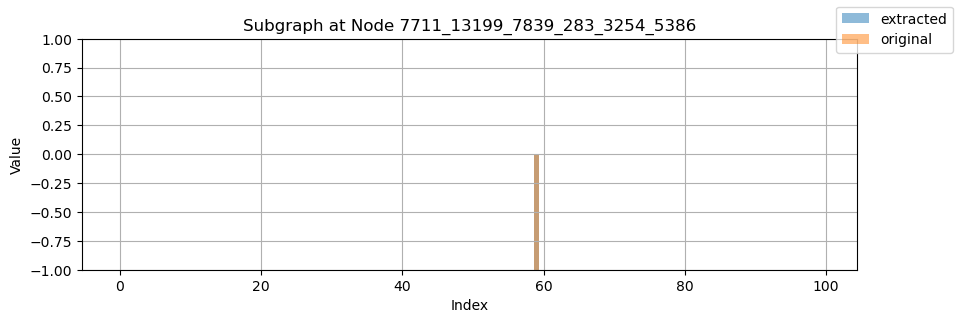

In [ ]:
for subgraph_central_node in list(history['betas'].keys())[:3]:
    fig, ax = plt.subplots(1, 1,figsize=(10,3))
    final_beta = history['betas'][subgraph_central_node][-1]
    extracted_watermark = copy.deepcopy(final_beta)#torch.sign(beta)
    extracted_watermark[extracted_watermark==0]=0
    extracted_watermark[extracted_watermark>0]=1
    extracted_watermark[extracted_watermark<0]=-1

    ax.bar(range(len(extracted_watermark[:100])),extracted_watermark[:100].numpy(),label='extracted',alpha=0.5)
    ax.bar(range(len(watermark[:100])),watermark[:100].numpy(),label='original',alpha=0.5)
    fig.legend()
    ax.set_title(f'Subgraph at Node {subgraph_central_node}')

    ax.set_xlabel('Index')  # X-axis label
    ax.set_ylabel('Value')  # Y-axis label
    ax.grid(True)  # Enable grid
    ax.set_ylim(-1,1)

In [ ]:
beta

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000, -1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.00

tensor(5.9284)


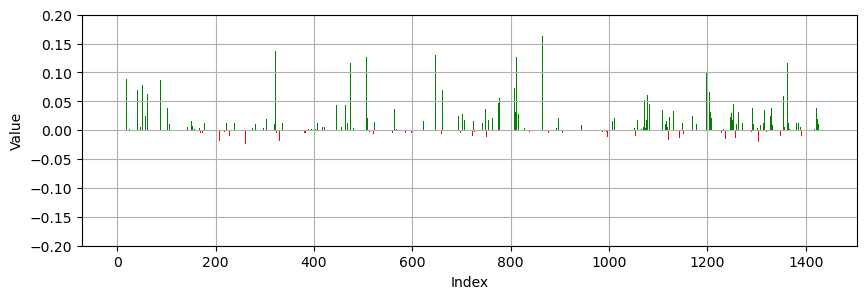

tensor(4.5475)


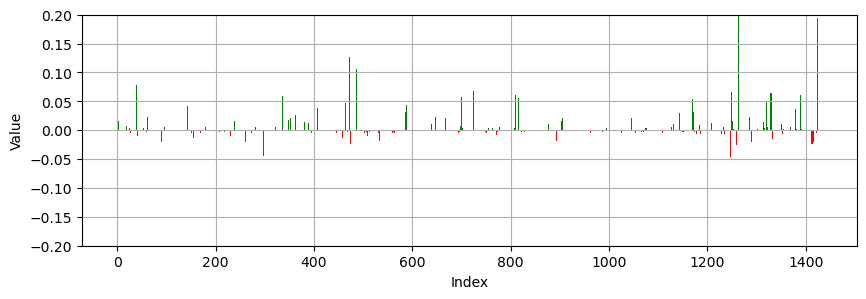

tensor(5.6710)


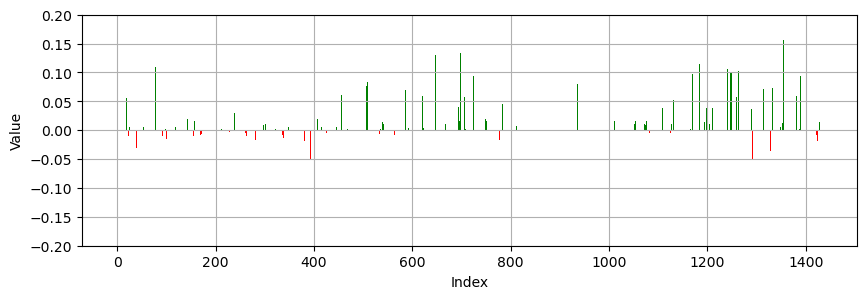

tensor(6.1949)


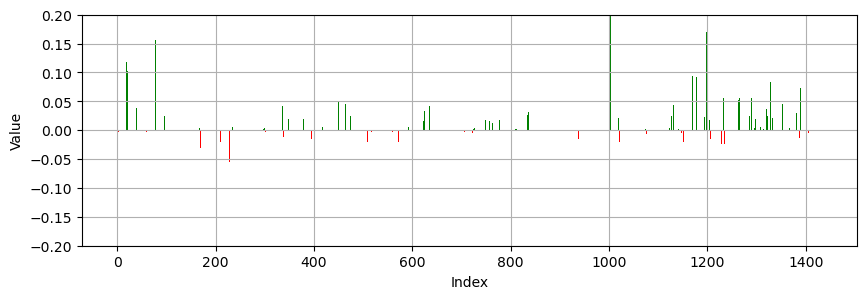

tensor(4.1550)


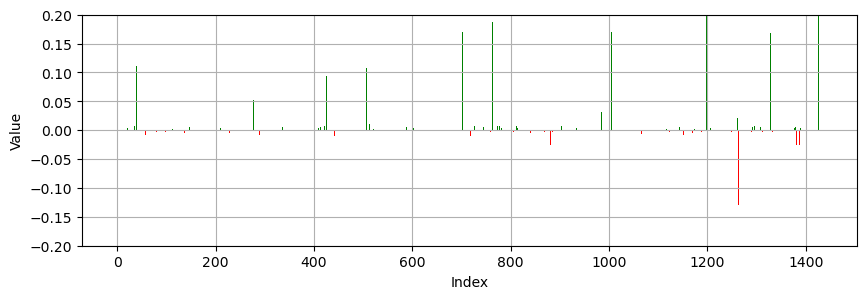

tensor(3.8974)


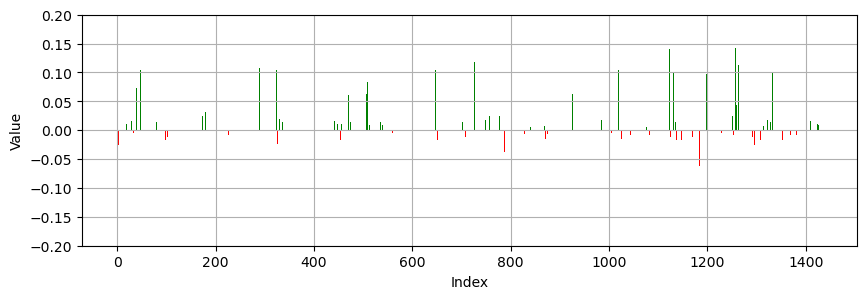

tensor(3.2936)


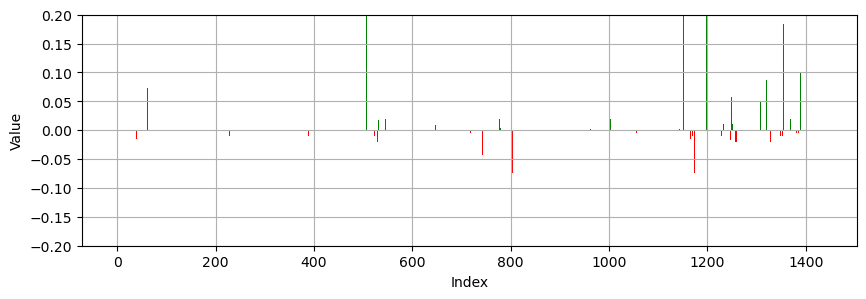

tensor(1.2718)


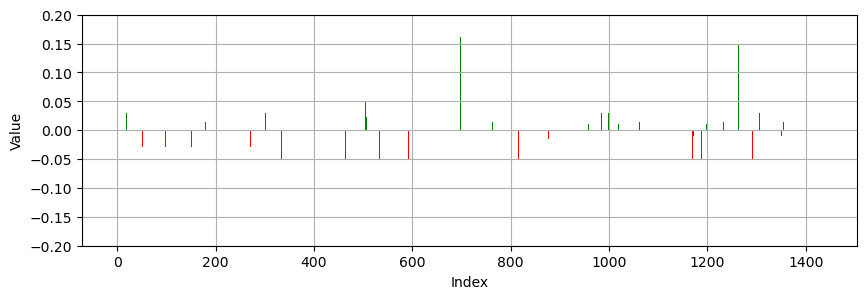

tensor(3.3792)


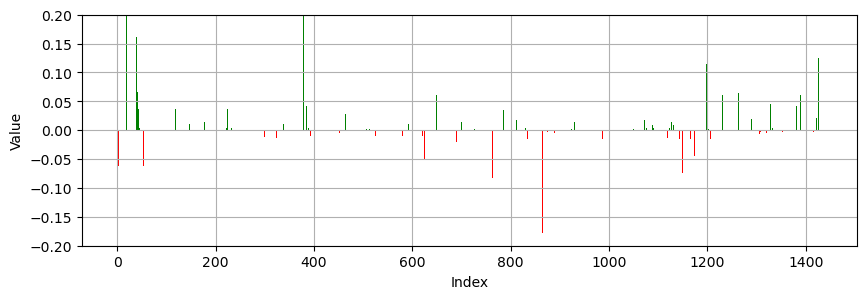

tensor(6.1817)


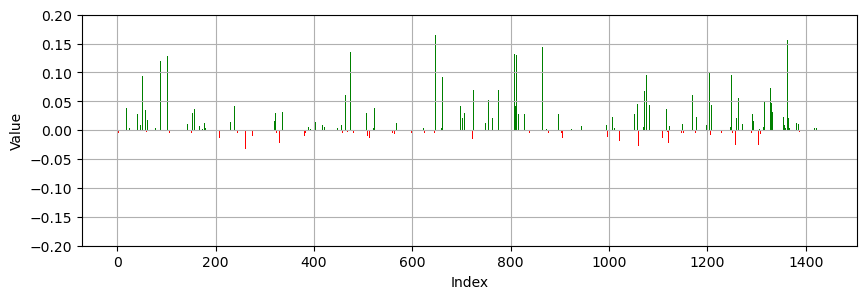

tensor(1.6128)


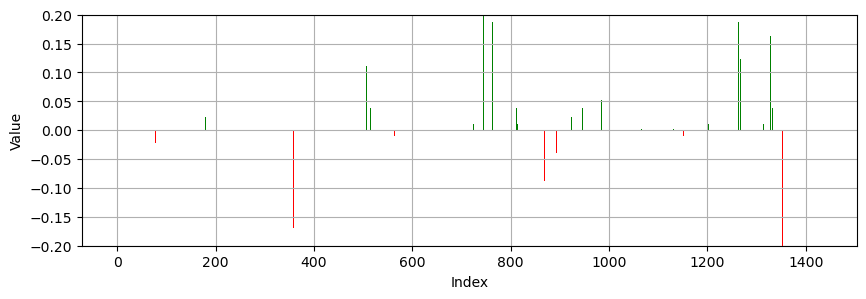

tensor(3.5882)


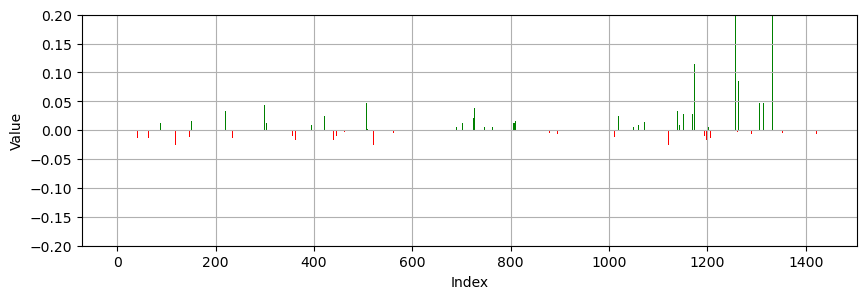

tensor(3.3046)


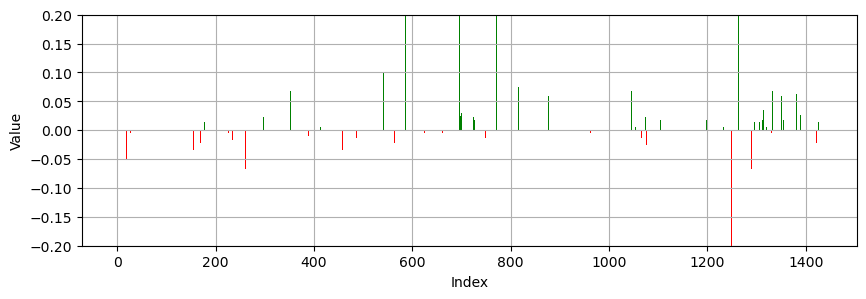

In [ ]:
frame=-1
# for frame in [0,-1]:
for central_node in history['betas'].keys():
    fig, ax = plt.subplots(1, 1,figsize=(10,3))
    beta = history['betas'][central_node][-1].clone().detach()
    extracted_watermark = copy.deepcopy(beta)#torch.sign(beta)
    extracted_watermark[extracted_watermark>=0]=1
    extracted_watermark[extracted_watermark<0]=-1

    same_betas, different_betas = copy.deepcopy(beta), copy.deepcopy(beta)
    same     = extracted_watermark==watermark
    not_same = extracted_watermark!=watermark

    same_betas[not_same]=0
    same_betas=torch.abs(same_betas)

    different_betas[same]=0
    different_betas=-torch.abs(different_betas)

    print(torch.sum(same_betas)+torch.sum(different_betas))
    

    ax.bar(range(len(same_betas)), same_betas.numpy(), color='green')
    ax.bar(range(len(different_betas)), different_betas.numpy(), color='red')
    ax.set_xlabel('Index')  # X-axis label
    ax.set_ylabel('Value')  # Y-axis label
    ax.grid(True)  # Enable grid
    ax.set_ylim(-0.2,0.2)
    plt.show()

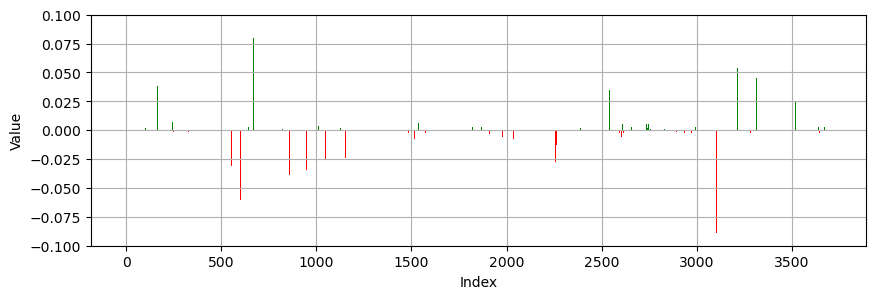

In [ ]:

fig, ax = plt.subplots(1, 1,figsize=(10,3))
def update(frame):
    ax.clear()
    beta = history['betas'][frame].clone().detach()
    extracted_watermark = copy.deepcopy(beta)#torch.sign(beta)
    extracted_watermark[extracted_watermark>0]=1
    extracted_watermark[extracted_watermark<0]=-1

    same_betas, different_betas = copy.deepcopy(beta), copy.deepcopy(beta)
    same     = extracted_watermark==watermark
    not_same = extracted_watermark!=watermark
    
    same_betas[not_same]=0
    same_betas=torch.abs(same_betas)

    different_betas[same]=0
    different_betas=-torch.abs(different_betas)

    ax.bar(range(len(same_betas)), same_betas.numpy(), color='green')
    ax.bar(range(len(different_betas)), different_betas.numpy(), color='red')
    ax.set_xlabel('Index')  # X-axis label
    ax.set_ylabel('Value')  # Y-axis label
    ax.grid(True)  # Enable grid
    ax.set_ylim(-0.1,0.1)
    return ax,

ani = FuncAnimation(fig, update, frames=len(history['betas']))
HTML(ani.to_jshtml())


# 